In [7]:
import pandas as pd
import numpy as np
import shap

In [8]:
seed = 123456

In [9]:
train = pd.read_csv('data_train.csv')

In [10]:
from sklearn.model_selection import StratifiedKFold
sp = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

In [11]:
from imblearn.over_sampling import RandomOverSampler
ous = RandomOverSampler()

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [138]:
import hyperopt
from hyperopt import hp

In [78]:
def objective(params):
    aucs = []
    for index,(train_index,vali_index) in enumerate(sp.split(train,train['type'])):
        data_train = train.iloc[train_index,:]
        data_vali = train.iloc[vali_index,:]
        X_train = data_train.iloc[:,1:-1]
        y_train = data_train.iloc[:,-1]
        X_vali = data_vali.iloc[:,1:-1]
        y_vali = data_vali.iloc[:,-1]
        X_train,y_train = ous.fit_resample(X_train,y_train)

        model = Sequential()
        model.add(Dense(units=params['l1'],input_dim=85,activation='relu'))
        model.add(Dropout(params['dr1']))
        model.add(Dense(units=params['l2'],activation='relu'))
        model.add(Dropout(params['dr2']))
        model.add(Dense(units=params['l3'],activation='relu'))
        model.add(Dropout(params['dr3']))
        model.add(Dense(units=1,activation='sigmoid'))

        call = EarlyStopping(monitor='val_auc',mode='max')
        op = Adam(learning_rate=params['lr'],beta_1=params['bt1'],beta_2=params['bt2'])
        model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

        his = model.fit(X_train,y_train,epochs=500,batch_size=1000,callbacks=call,validation_data=(X_vali,y_vali))
        aucs.append(his.history['val_auc'][-1])
    return -np.mean(aucs)

In [79]:
space = {
    'l1':hp.choice('l1',range(2,100)),
    'l2':hp.choice('l2',range(2,100)),
    'l3':hp.choice('l3',range(2,100)),
    'dr1':hp.uniform('dr1',0,1),
    'dr2':hp.uniform('dr2',0,1),
    'dr3':hp.uniform('dr3',0,1),
    'lr':hp.uniform('lr',0,1),
    'bt1':hp.uniform('bt1',0,1),
    'bt2':hp.uniform('bt2',0,1)
}

In [80]:
best_params = hyperopt.fmin(objective, space, algo=hyperopt.tpe.suggest, max_evals=50)

Epoch 1/500                                           

8/8 [==============================] - 1s 46ms/step - loss: 56.3662 - auc: 0.5071 - val_loss: 2.4949 - val_auc: 0.5055

Epoch 2/500                                           

8/8 [==============================] - 0s 10ms/step - loss: 1.1244 - auc: 0.4915 - val_loss: 0.8108 - val_auc: 0.5000

Epoch 1/500                                           

8/8 [==============================] - 1s 38ms/step - loss: 60.5719 - auc: 0.4909 - val_loss: 0.7392 - val_auc: 0.5023

Epoch 2/500                                           

8/8 [==============================] - 0s 12ms/step - loss: 1.1185 - auc: 0.5007 - val_loss: 0.6434 - val_auc: 0.5011

Epoch 1/500                                           

8/8 [==============================] - 1s 38ms/step - loss: 461.9406 - auc: 0.5033 - val_loss: 0.6713 - val_auc: 0.5000

Epoch 2/500                                           

8/8 [==============================] - 0s 10ms/step - loss: 0.703

In [81]:
best_params

{'bt1': 0.5533628888067178,
 'bt2': 0.7147232869127088,
 'dr1': 0.5922756737163298,
 'dr2': 0.24259120546024865,
 'dr3': 0.024606085997426252,
 'l1': 38,
 'l2': 74,
 'l3': 96,
 'lr': 0.008017269518094929}

In [85]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [86]:
tprs_train = []
tprs_vali = []
fprs = np.linspace(0,1,100)
aucs_train = []
aucs_vali = []
th_tpr = []
th_fpr = []
th_th = []
for index,(train_index,vali_index) in enumerate(sp.split(train,train['type'])):
    data_train = train.iloc[train_index,:]
    data_vali = train.iloc[vali_index,:]
    X_train = data_train.iloc[:,1:-1]
    y_train = data_train.iloc[:,-1]
    X_vali = data_vali.iloc[:,1:-1]
    y_vali = data_vali.iloc[:,-1]
    X_train,y_train = ous.fit_resample(X_train,y_train)

    model = Sequential()
    model.add(Dense(units=39,input_dim=85,activation='relu'))
    model.add(Dropout(0.5922756737163298))
    model.add(Dense(units=75,activation='relu'))
    model.add(Dropout(0.24259120546024865))
    model.add(Dense(units=97,activation='relu'))
    model.add(Dropout(0.024606085997426252))
    model.add(Dense(units=1,activation='sigmoid'))

    call = EarlyStopping(monitor='val_auc',mode='max')
    op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
    model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

    model.fit(X_train,y_train,epochs=500,batch_size=1000,callbacks=call,validation_data=(X_vali,y_vali))

    pro_train = model.predict(X_train)
    pro_vali = model.predict(X_vali)
    fpr_train,tpr_train,th_train = roc_curve(y_train,pro_train)
    fpr_vali,tpr_vali,th_vali = roc_curve(y_vali,pro_vali)
    auc_train = roc_auc_score(y_train,pro_train)
    auc_vali = roc_auc_score(y_vali,pro_vali)

    tprs_train.append(np.interp(fprs,fpr_train,tpr_train))
    tprs_vali.append(np.interp(fprs,fpr_vali,tpr_vali))
    aucs_train.append(auc_train)
    aucs_vali.append(auc_vali)

    th_tpr.append(tpr_vali)
    th_fpr.append(fpr_vali)
    th_th.append(th_vali)

Epoch 1/500
8/8 [==============================] - 1s 39ms/step - loss: 0.6897 - auc: 0.5937 - val_loss: 0.5526 - val_auc: 0.8097
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5779 - auc: 0.7677 - val_loss: 0.5657 - val_auc: 0.8315
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5492 - auc: 0.7968 - val_loss: 0.4940 - val_auc: 0.8377
Epoch 4/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5310 - auc: 0.8123 - val_loss: 0.5415 - val_auc: 0.8390
Epoch 5/500
41/41 [==============================] - 0s 947us/step
Epoch 1/500
8/8 [==============================] - 3s 274ms/step - loss: 0.7180 - auc: 0.5666 - val_loss: 0.5902 - val_auc: 0.8087
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 0.5894 - auc: 0.7592 - val_loss: 0.5683 - val_auc: 0.8273
Epoch 3/500
8/8 [==============================] - 0s 14ms/step - loss: 0.5469 - auc: 0.7980 - val_loss: 0.5343 - val_auc: 0.8333
Epoch 4/500
8/8 [=====

In [87]:
for i in range(len(tprs_train)):
    tprs_train[i][0] = 0
    tprs_vali[i][0] = 0

In [9]:
import matplotlib.pyplot as plt

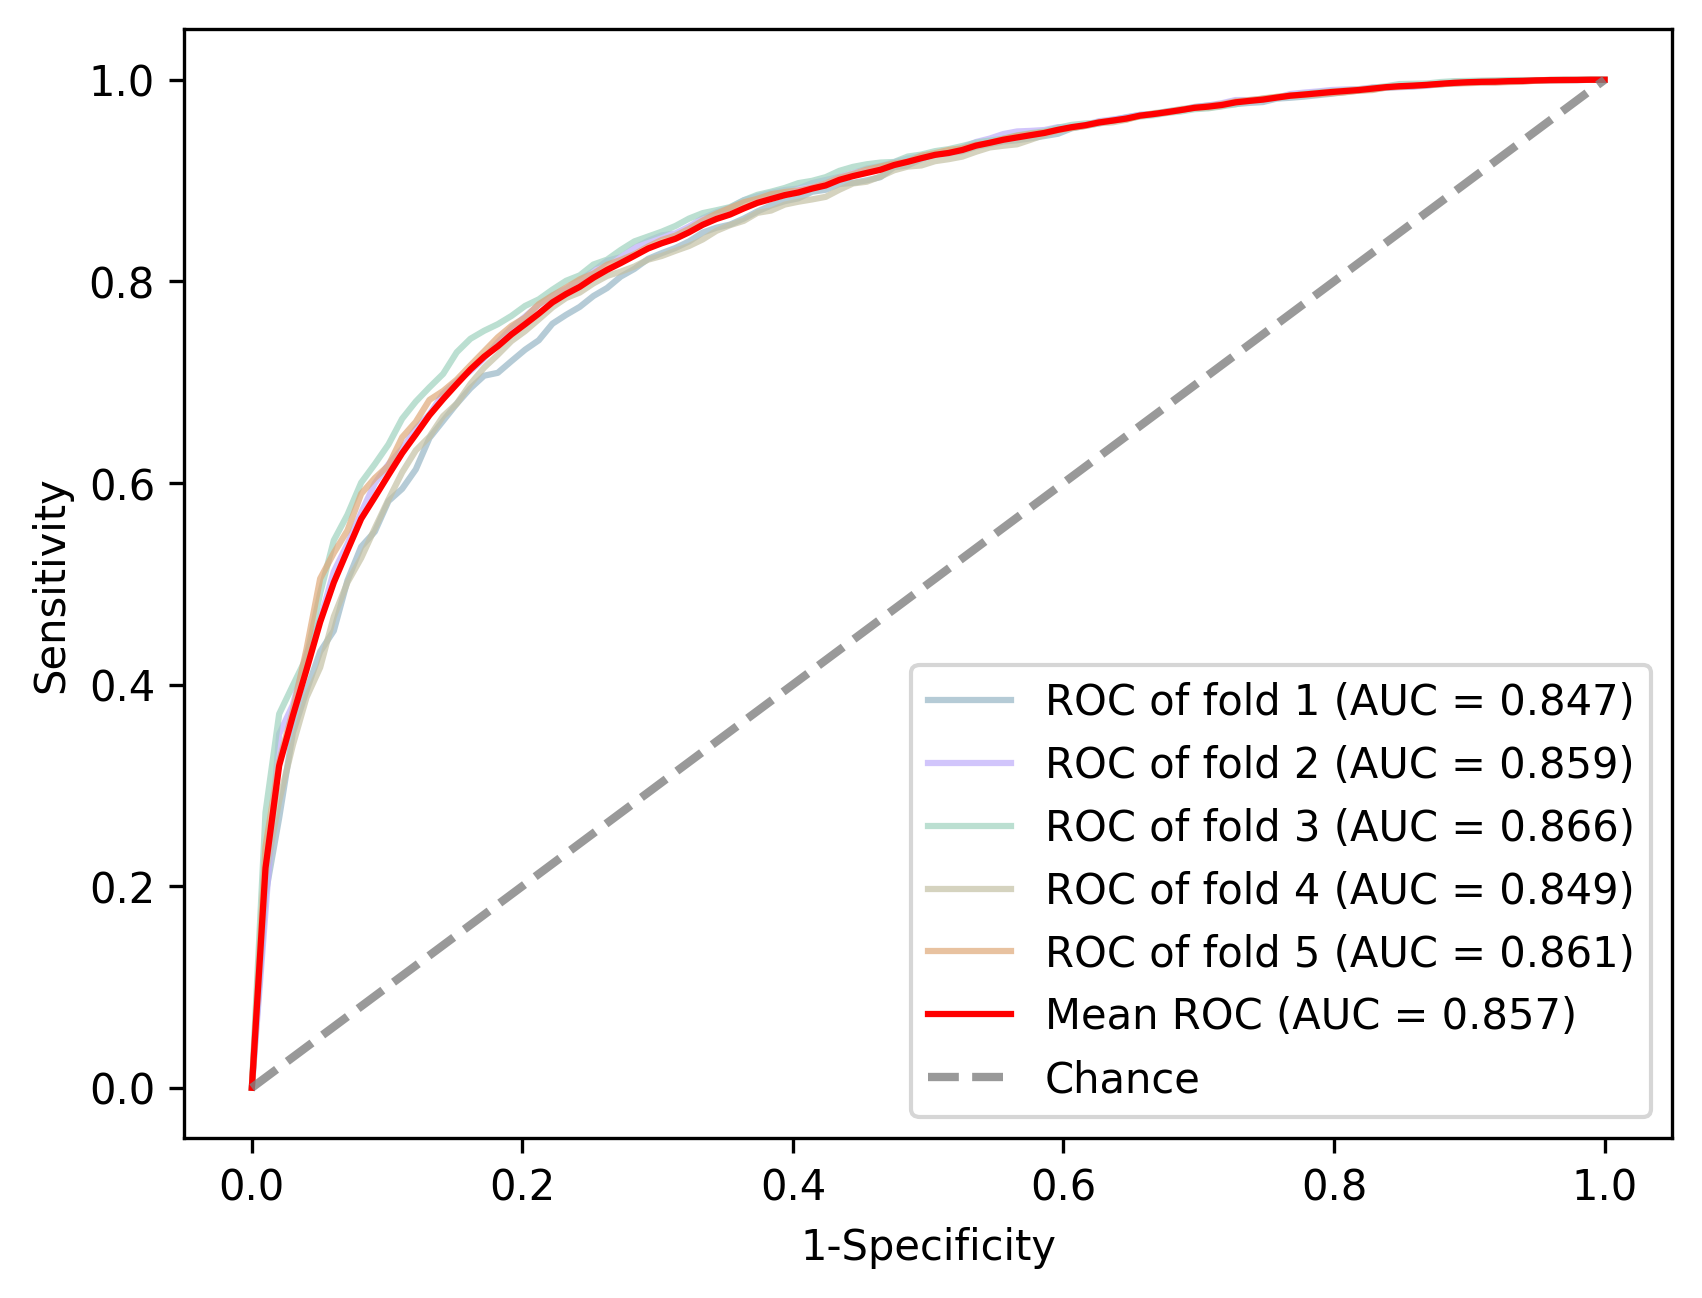

In [89]:
plt.figure(dpi=300)
plt.plot(fprs,tprs_train[0],color='#96B6C5',alpha=0.7,label='ROC of fold 1 (AUC = {:.3f})'.format(aucs_train[0]))
plt.plot(fprs,tprs_train[1],color='#BEADFA',alpha=0.7,label='ROC of fold 2 (AUC = {:.3f})'.format(aucs_train[1]))
plt.plot(fprs,tprs_train[2],color='#9ED2BE',alpha=0.7,label='ROC of fold 3 (AUC = {:.3f})'.format(aucs_train[2]))
plt.plot(fprs,tprs_train[3],color='#C4C1A4',alpha=0.7,label='ROC of fold 4 (AUC = {:.3f})'.format(aucs_train[3]))
plt.plot(fprs,tprs_train[4],color='#DFA878',alpha=0.7,label='ROC of fold 5 (AUC = {:.3f})'.format(aucs_train[4]))
plt.plot(fprs,np.average(tprs_train,axis=0),color='red',label='Mean ROC (AUC = {:.3f})'.format(np.mean(aucs_train)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',label='Chance', alpha=.8)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend()

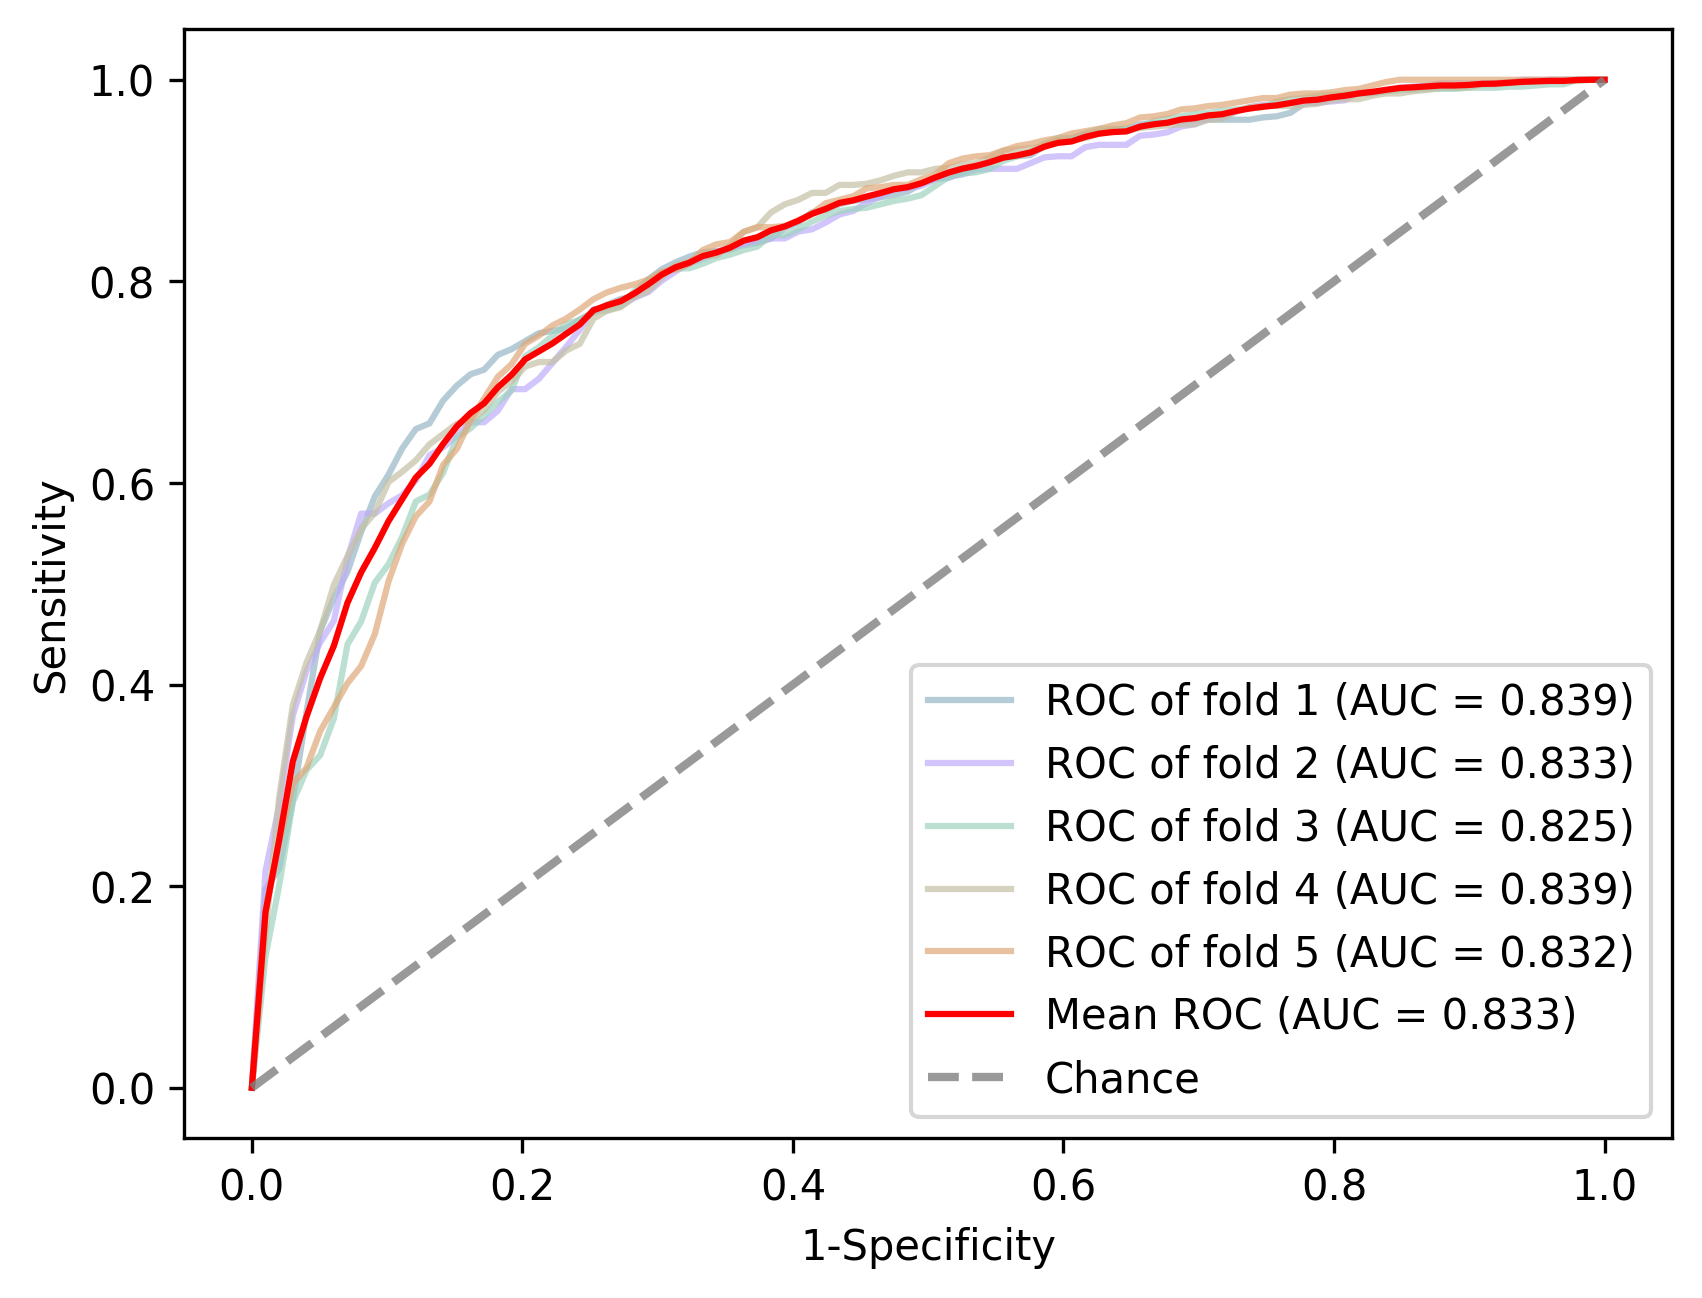

In [90]:
plt.figure(dpi=300)
plt.plot(fprs,tprs_vali[0],color='#96B6C5',alpha=0.7,label='ROC of fold 1 (AUC = {:.3f})'.format(aucs_vali[0]))
plt.plot(fprs,tprs_vali[1],color='#BEADFA',alpha=0.7,label='ROC of fold 2 (AUC = {:.3f})'.format(aucs_vali[1]))
plt.plot(fprs,tprs_vali[2],color='#9ED2BE',alpha=0.7,label='ROC of fold 3 (AUC = {:.3f})'.format(aucs_vali[2]))
plt.plot(fprs,tprs_vali[3],color='#C4C1A4',alpha=0.7,label='ROC of fold 4 (AUC = {:.3f})'.format(aucs_vali[3]))
plt.plot(fprs,tprs_vali[4],color='#DFA878',alpha=0.7,label='ROC of fold 5 (AUC = {:.3f})'.format(aucs_vali[4]))
plt.plot(fprs,np.average(tprs_vali,axis=0),color='red',label='Mean ROC (AUC = {:.3f})'.format(np.mean(aucs_vali)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',label='Chance', alpha=.8)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend()

In [96]:
test = pd.read_csv('data_test.csv')
X_test = test.iloc[:,1:-1]
y_test = test.iloc[:,-1]

X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])

model = Sequential()
model.add(Dense(units=39,input_dim=85,activation='relu'))
model.add(Dropout(0.5922756737163298))
model.add(Dense(units=75,activation='relu'))
model.add(Dropout(0.24259120546024865))
model.add(Dense(units=97,activation='relu'))
model.add(Dropout(0.024606085997426252))
model.add(Dense(units=1,activation='sigmoid'))

call = EarlyStopping(monitor='val_auc',mode='max')
op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

his = model.fit(X_new,y_new,batch_size=1000,epochs=7)

pro_test = model.predict(X_test)
fpr_test,tpr_test,th_test = roc_curve(y_test,pro_test)
auc_test = roc_auc_score(y_test,pro_test)

Epoch 1/7
9/9 [==============================] - 1s 6ms/step - loss: 0.6499 - auc: 0.6567
Epoch 2/7
9/9 [==============================] - 0s 7ms/step - loss: 0.5647 - auc: 0.7833
Epoch 3/7
9/9 [==============================] - 0s 7ms/step - loss: 0.5316 - auc: 0.8118
Epoch 4/7
9/9 [==============================] - 0s 7ms/step - loss: 0.5180 - auc: 0.8237
Epoch 5/7
9/9 [==============================] - 0s 6ms/step - loss: 0.5116 - auc: 0.8282
Epoch 6/7
9/9 [==============================] - 0s 7ms/step - loss: 0.4993 - auc: 0.8375
Epoch 7/7
20/20 [==============================] - 0s 892us/step


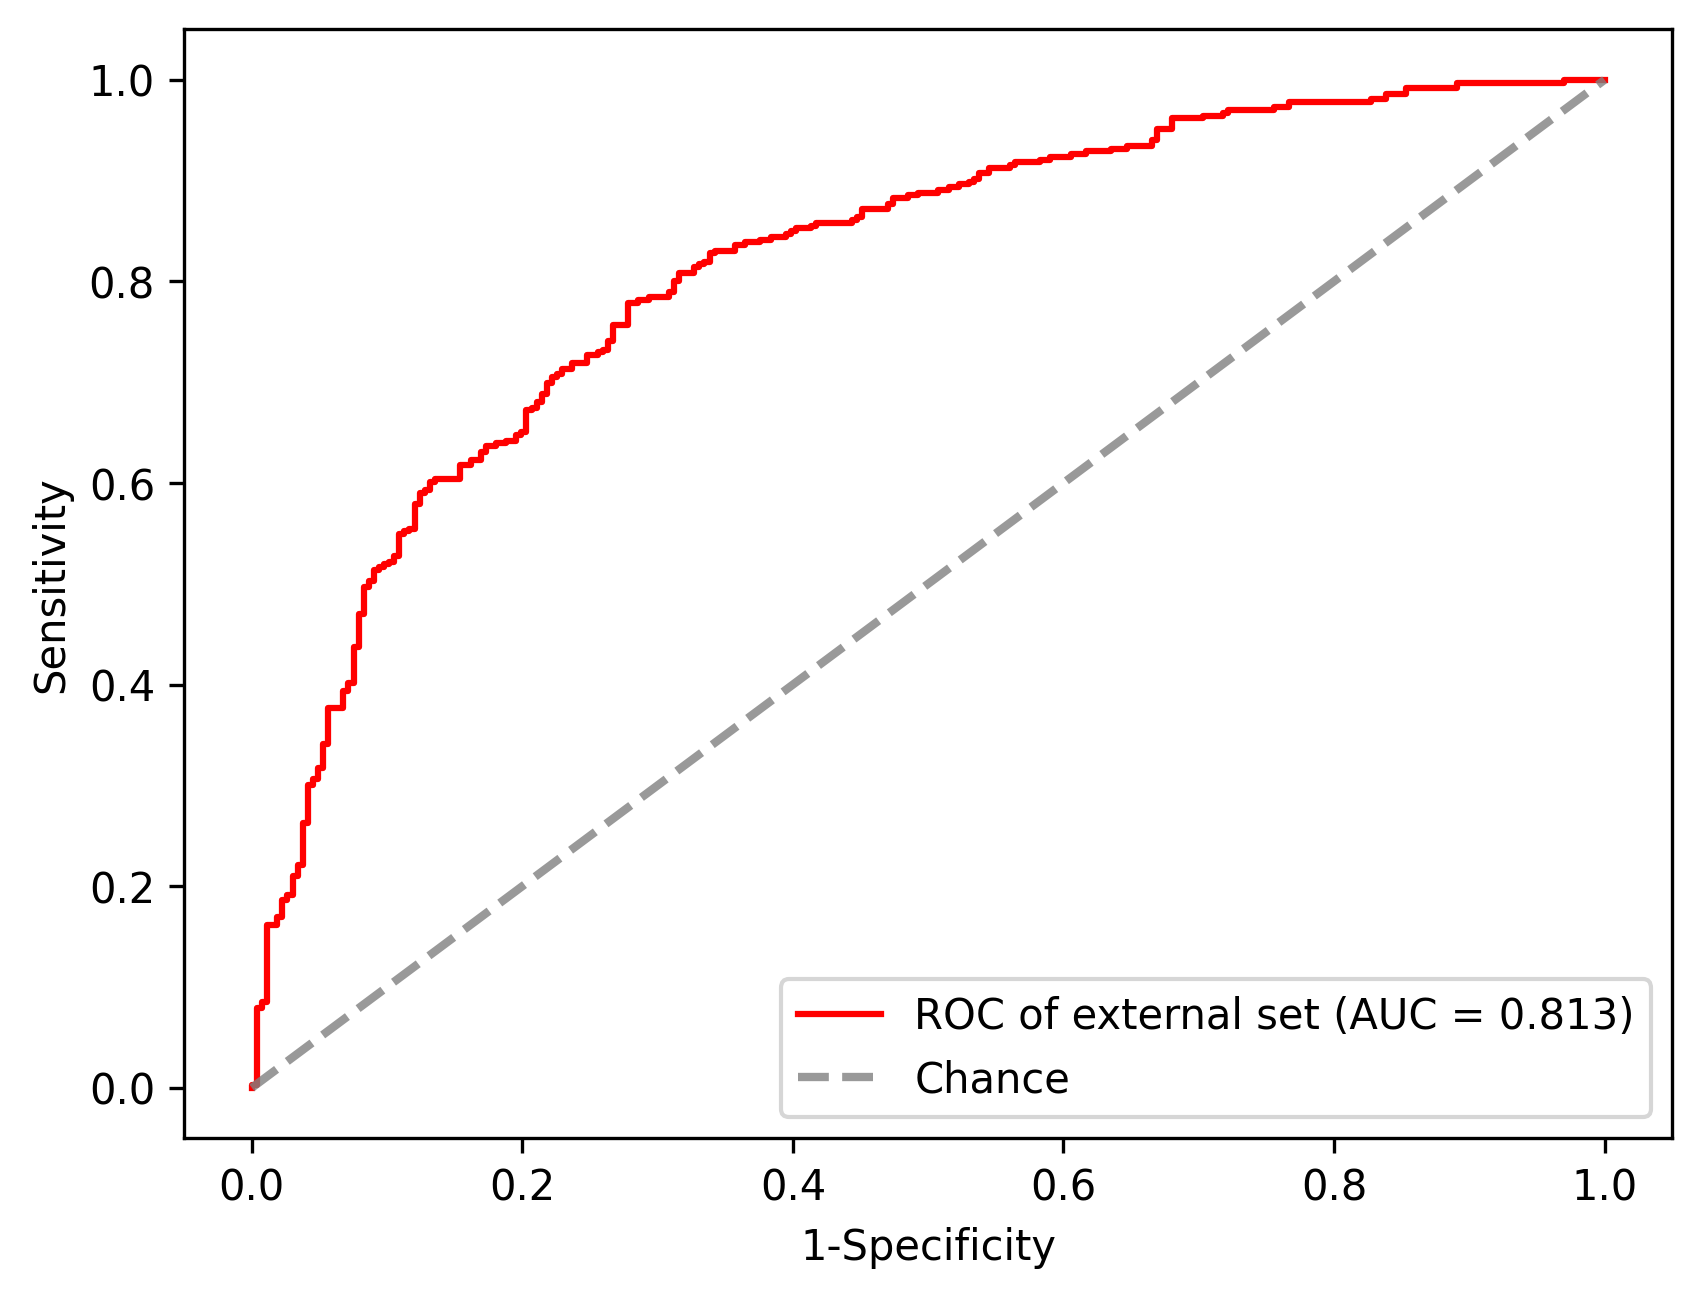

In [97]:
plt.figure(dpi=300)
plt.plot(fpr_test,tpr_test,color='red',label='ROC of external set (AUC = {:.3f})'.format(auc_test))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',label='Chance', alpha=.8)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend()

In [98]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold

In [99]:
print(Find_Optimal_Cutoff(th_tpr[0],th_fpr[0],th_th[0]))
print(Find_Optimal_Cutoff(th_tpr[1],th_fpr[1],th_th[1]))
print(Find_Optimal_Cutoff(th_tpr[2],th_fpr[2],th_th[2]))
print(Find_Optimal_Cutoff(th_tpr[3],th_fpr[3],th_th[3]))
print(Find_Optimal_Cutoff(th_tpr[4],th_fpr[4],th_th[4]))
mean_th = 0.45

0.5752404
0.40711296
0.4538457
0.5275288
0.44156224


In [100]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score
def NPV(Y_true,Y_pre):
    Y_true = pd.DataFrame(Y_true)
    Y_pre = pd.DataFrame(Y_pre)
    hb = pd.concat([Y_true.reset_index(drop=True),Y_pre],axis=1,ignore_index=True)
    tn = hb[(hb[0]==0) & (hb[1]==0)].shape[0]
    fn = hb[(hb[0]==1) & (hb[1]==0)].shape[0]
    return tn/(tn+fn)

In [101]:
for index,(train_index,vali_index) in enumerate(sp.split(train,train['type'])):
    data_train = train.iloc[train_index,:]
    data_vali = train.iloc[vali_index,:]
    X_train = data_train.iloc[:,1:-1]
    y_train = data_train.iloc[:,-1]
    X_vali = data_vali.iloc[:,1:-1]
    y_vali = data_vali.iloc[:,-1]
    X_train,y_train = ous.fit_resample(X_train,y_train)

    model = Sequential()
    model.add(Dense(units=39,input_dim=85,activation='relu'))
    model.add(Dropout(0.5922756737163298))
    model.add(Dense(units=75,activation='relu'))
    model.add(Dropout(0.24259120546024865))
    model.add(Dense(units=97,activation='relu'))
    model.add(Dropout(0.024606085997426252))
    model.add(Dense(units=1,activation='sigmoid'))

    call = EarlyStopping(monitor='val_auc',mode='max')
    op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
    model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

    model.fit(X_train,y_train,epochs=500,batch_size=1000,callbacks=call,validation_data=(X_vali,y_vali))

    pro_train = model.predict(X_train)
    pro_vali = model.predict(X_vali)
    pre_train = np.where(pro_train >= mean_th,1,0)
    pre_vali = np.where(pro_vali >= mean_th,1,0)

    acc_train = accuracy_score(y_train,pre_train)
    acc_vali = accuracy_score(y_vali,pre_vali)
    repor_train = classification_report_imbalanced(y_train,pre_train).split()
    repor_vali = classification_report_imbalanced(y_vali,pre_vali).split()
    sensitivity_train = repor_train[17]
    sensitivity_vali = repor_vali[17]
    specificity_train = repor_train[18]
    specificity_vali = repor_vali[18]
    f1_train = repor_train[19]
    f1_vali = repor_vali[19]
    ppv_train = repor_train[16]
    ppv_vali = repor_vali[16]
    npv_train = NPV(y_train,pre_train)
    npv_vali = NPV(y_vali,pre_vali)

    if index==0:
        with open('metric_DeepLearning.txt','w') as f:
            f.write('训练集_fold {}\n'.format(index+1))
            f.write('Accuracy:{}\n'.format(acc_train))
            f.write('Sensitivity:{}\n'.format(sensitivity_train))
            f.write('Specificity:{}\n'.format(specificity_train))
            f.write('PPV:{}\n'.format(ppv_train))
            f.write('NPV:{}\n'.format(npv_train))
            f.write('F1 score:{}\n'.format(f1_train))
            f.write('\n')
            f.write('验证集_fold {}\n'.format(index+1))
            f.write('Accuracy:{}\n'.format(acc_vali))
            f.write('Sensitivity:{}\n'.format(sensitivity_vali))
            f.write('Specificity:{}\n'.format(specificity_vali))
            f.write('PPV:{}\n'.format(ppv_vali))
            f.write('NPV:{}\n'.format(npv_vali))
            f.write('F1 score:{}\n'.format(f1_vali))
            f.write('\n\n')
    else:
        with open('metric_DeepLearning.txt','a') as f:
            f.write('训练集_fold {}\n'.format(index+1))
            f.write('Accuracy:{}\n'.format(acc_train))
            f.write('Sensitivity:{}\n'.format(sensitivity_train))
            f.write('Specificity:{}\n'.format(specificity_train))
            f.write('PPV:{}\n'.format(ppv_train))
            f.write('NPV:{}\n'.format(npv_train))
            f.write('F1 score:{}\n'.format(f1_train))
            f.write('\n')
            f.write('验证集_fold {}\n'.format(index+1))
            f.write('Accuracy:{}\n'.format(acc_vali))
            f.write('Sensitivity:{}\n'.format(sensitivity_vali))
            f.write('Specificity:{}\n'.format(specificity_vali))
            f.write('PPV:{}\n'.format(ppv_vali))
            f.write('NPV:{}\n'.format(npv_vali))
            f.write('F1 score:{}\n'.format(f1_vali))
            f.write('\n\n')

Epoch 1/500
8/8 [==============================] - 2s 40ms/step - loss: 0.7151 - auc: 0.5690 - val_loss: 0.5707 - val_auc: 0.7929
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5872 - auc: 0.7592 - val_loss: 0.5391 - val_auc: 0.8291
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5470 - auc: 0.7984 - val_loss: 0.4855 - val_auc: 0.8360
Epoch 4/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5313 - auc: 0.8122 - val_loss: 0.4710 - val_auc: 0.8383
Epoch 5/500
8/8 [==============================] - 0s 12ms/step - loss: 0.5241 - auc: 0.8194 - val_loss: 0.5143 - val_auc: 0.8409
Epoch 6/500
8/8 [==============================] - 0s 12ms/step - loss: 0.5106 - auc: 0.8292 - val_loss: 0.5091 - val_auc: 0.8410
Epoch 7/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5053 - auc: 0.8332 - val_loss: 0.5255 - val_auc: 0.8422
Epoch 8/500
41/41 [==============================] - 0s 898us/step
Epoch 1/500
8/8 [======

In [102]:
test = pd.read_csv('data_test.csv')
X_test = test.iloc[:,1:-1]
y_test = test.iloc[:,-1]

X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])

model = Sequential()
model.add(Dense(units=39,input_dim=85,activation='relu'))
model.add(Dropout(0.5922756737163298))
model.add(Dense(units=75,activation='relu'))
model.add(Dropout(0.24259120546024865))
model.add(Dense(units=97,activation='relu'))
model.add(Dropout(0.024606085997426252))
model.add(Dense(units=1,activation='sigmoid'))

call = EarlyStopping(monitor='val_auc',mode='max')
op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

his = model.fit(X_new,y_new,batch_size=1000,epochs=7)

pro_test = model.predict(X_test)
pre_test = np.where(pro_test>=mean_th,1,0)

acc_test = accuracy_score(y_test,pre_test)
repor_test = classification_report_imbalanced(y_test,pre_test).split()
sensitivity_test = repor_test[17]
specificity_test = repor_test[18]
f1_test = repor_test[19]
ppv_test = repor_test[16]
npv_test = NPV(y_test,pre_test)

Epoch 1/7
9/9 [==============================] - 1s 7ms/step - loss: 0.6468 - auc: 0.6656
Epoch 2/7
9/9 [==============================] - 0s 7ms/step - loss: 0.5523 - auc: 0.7942
Epoch 3/7
9/9 [==============================] - 0s 7ms/step - loss: 0.5299 - auc: 0.8131
Epoch 4/7
9/9 [==============================] - 0s 11ms/step - loss: 0.5234 - auc: 0.8213
Epoch 5/7
9/9 [==============================] - 0s 8ms/step - loss: 0.5042 - auc: 0.8347
Epoch 6/7
9/9 [==============================] - 0s 7ms/step - loss: 0.5006 - auc: 0.8370
Epoch 7/7
20/20 [==============================] - 0s 997us/step


In [103]:
with open('metric_test.txt','w') as f:
    f.write('Accuracy:{}\n'.format(acc_test))
    f.write('Sensitivity:{}\n'.format(sensitivity_test))
    f.write('Specificity:{}\n'.format(specificity_test))
    f.write('PPV:{}\n'.format(ppv_test))
    f.write('NPV:{}\n'.format(npv_test))
    f.write('F1 score:{}\n'.format(f1_test))

In [104]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [105]:
ps_train = []
ps_vali = []
rs = np.linspace(0,1,100)
aps_train = []
aps_vali = []
for index,(train_index,vali_index) in enumerate(sp.split(train,train['type'])):
    data_train = train.iloc[train_index,:]
    data_vali = train.iloc[vali_index,:]
    X_train = data_train.iloc[:,1:-1]
    y_train = data_train.iloc[:,-1]
    X_vali = data_vali.iloc[:,1:-1]
    y_vali = data_vali.iloc[:,-1]
    X_train,y_train = ous.fit_resample(X_train,y_train)

    model = Sequential()
    model.add(Dense(units=39,input_dim=85,activation='relu'))
    model.add(Dropout(0.5922756737163298))
    model.add(Dense(units=75,activation='relu'))
    model.add(Dropout(0.24259120546024865))
    model.add(Dense(units=97,activation='relu'))
    model.add(Dropout(0.024606085997426252))
    model.add(Dense(units=1,activation='sigmoid'))

    call = EarlyStopping(monitor='val_auc',mode='max')
    op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
    model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

    model.fit(X_train,y_train,epochs=500,batch_size=1000,callbacks=call,validation_data=(X_vali,y_vali))

    pro_train = model.predict(X_train)
    pro_vali = model.predict(X_vali)

    p_train,r_train,th = precision_recall_curve(y_train,pro_train)
    p_vali,r_vali,th_vali = precision_recall_curve(y_vali,pro_vali)
    ap_train = average_precision_score(y_train,pro_train)
    ap_vali = average_precision_score(y_vali,pro_vali)
    ps_train.append(np.interp(rs,p_train,r_train))
    ps_vali.append(np.interp(rs,p_vali,r_vali))
    aps_train.append(ap_train)
    aps_vali.append(ap_vali)

Epoch 1/500
8/8 [==============================] - 2s 42ms/step - loss: 0.6585 - auc: 0.6417 - val_loss: 0.5506 - val_auc: 0.8104
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5809 - auc: 0.7624 - val_loss: 0.5217 - val_auc: 0.8216
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5470 - auc: 0.7983 - val_loss: 0.5446 - val_auc: 0.8325
Epoch 4/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5295 - auc: 0.8119 - val_loss: 0.5214 - val_auc: 0.8355
Epoch 5/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5201 - auc: 0.8216 - val_loss: 0.4746 - val_auc: 0.8413
Epoch 6/500
41/41 [==============================] - 0s 1ms/step
Epoch 1/500
8/8 [==============================] - 2s 39ms/step - loss: 0.6703 - auc: 0.6098 - val_loss: 0.5068 - val_auc: 0.7990
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5890 - auc: 0.7551 - val_loss: 0.4766 - val_auc: 0.8199
Epoch 3/500
8/8 [========

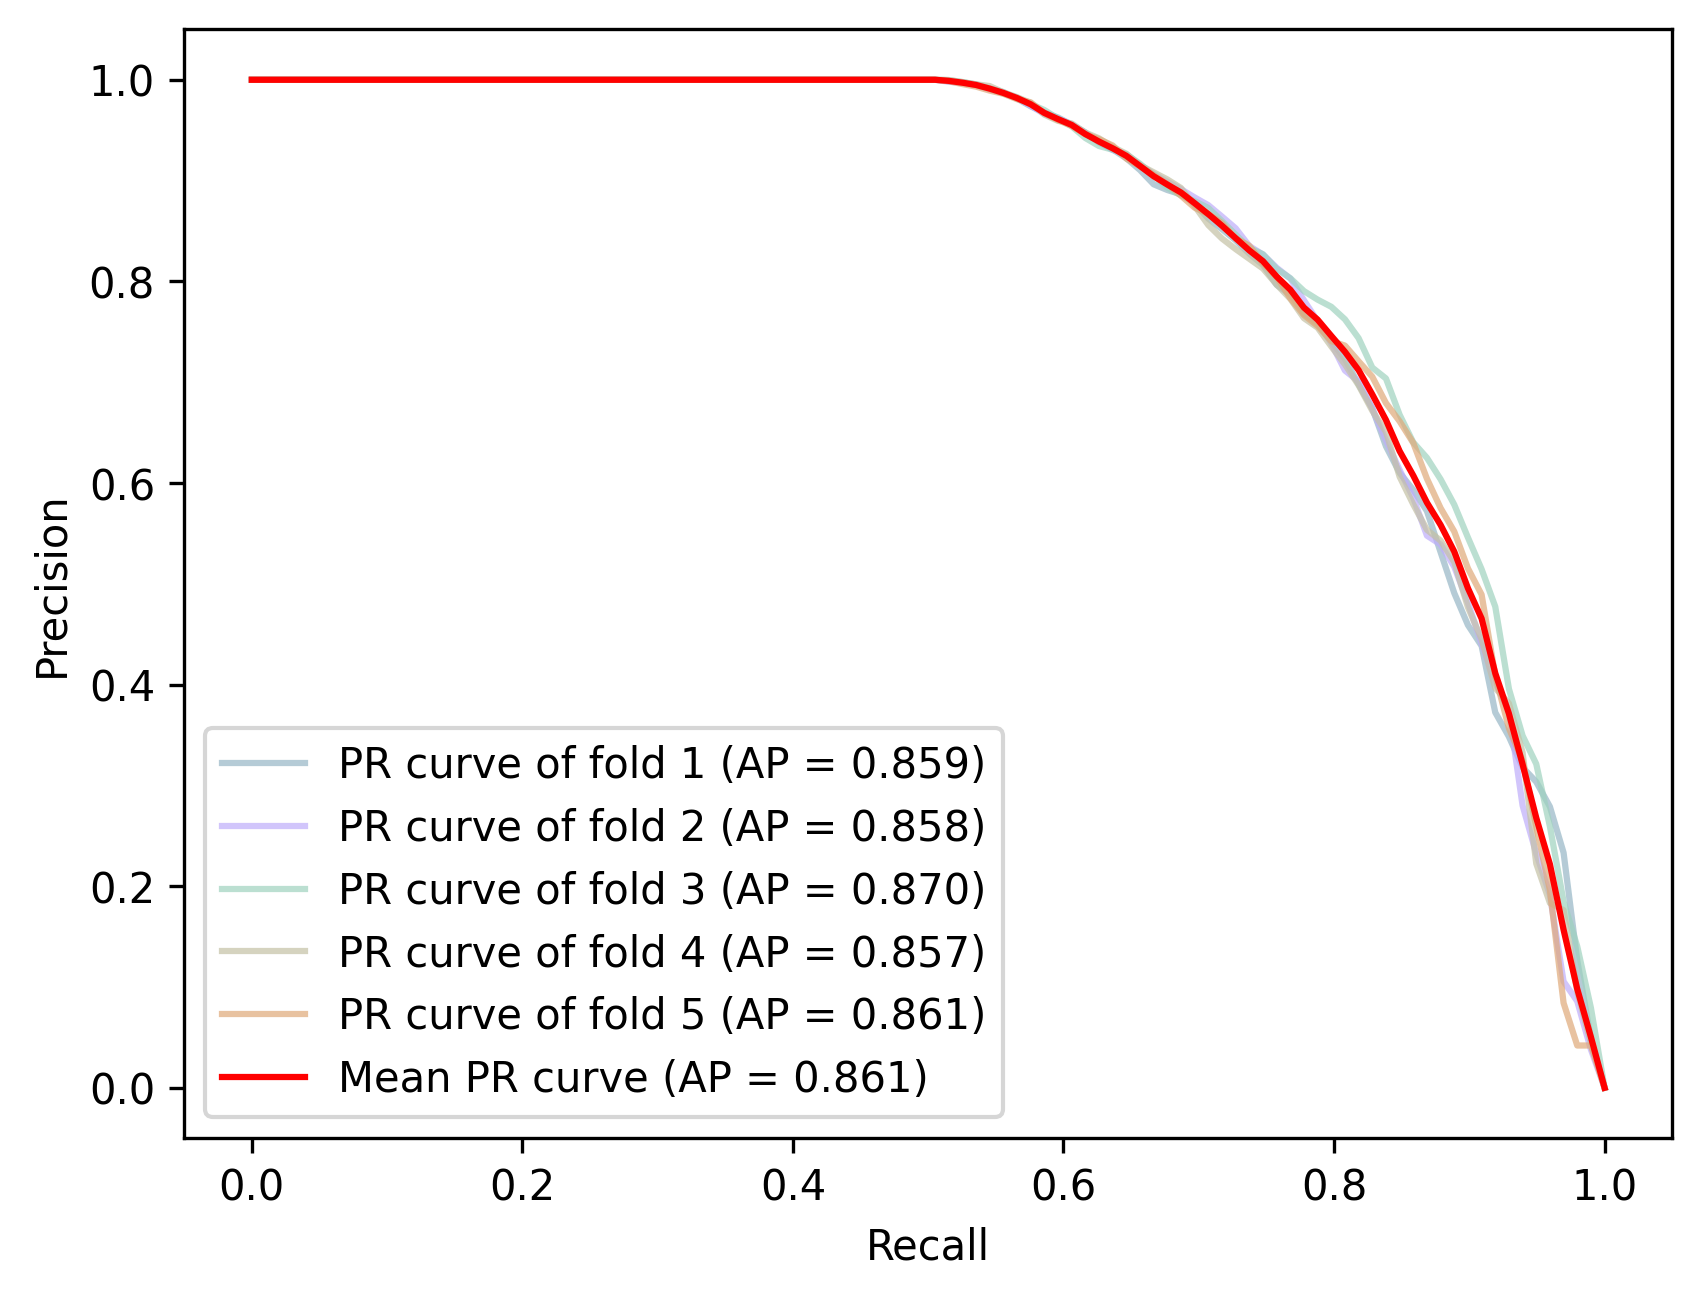

In [106]:
plt.figure(dpi=300)
plt.plot(rs,ps_train[0],color='#96B6C5',alpha=0.7,label='PR curve of fold 1 (AP = {:.3f})'.format(aps_train[0]))
plt.plot(rs,ps_train[1],color='#BEADFA',alpha=0.7,label='PR curve of fold 2 (AP = {:.3f})'.format(aps_train[1]))
plt.plot(rs,ps_train[2],color='#9ED2BE',alpha=0.7,label='PR curve of fold 3 (AP = {:.3f})'.format(aps_train[2]))
plt.plot(rs,ps_train[3],color='#C4C1A4',alpha=0.7,label='PR curve of fold 4 (AP = {:.3f})'.format(aps_train[3]))
plt.plot(rs,ps_train[4],color='#DFA878',alpha=0.7,label='PR curve of fold 5 (AP = {:.3f})'.format(aps_train[4]))
plt.plot(rs,np.average(ps_train,axis=0),color='red',label='Mean PR curve (AP = {:.3f})'.format(np.mean(aps_train)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()

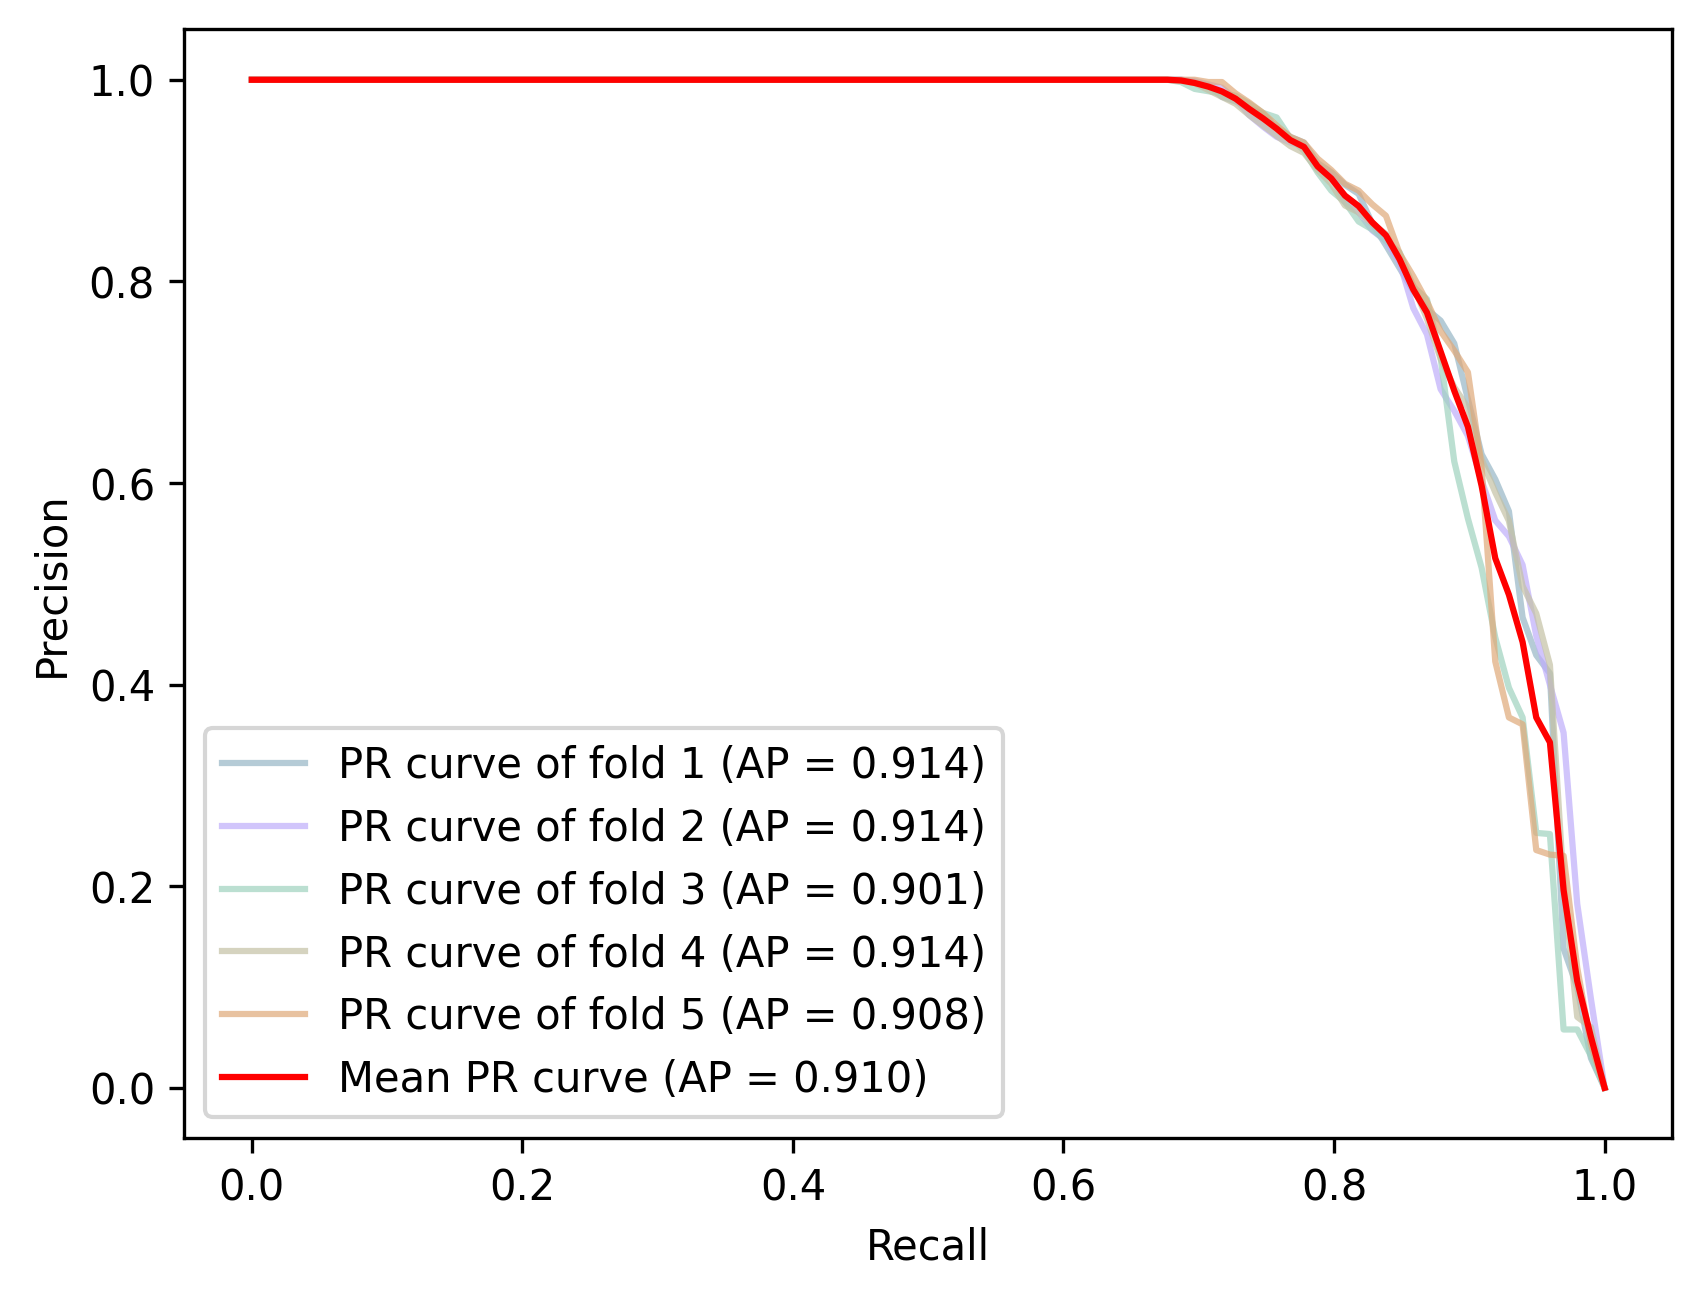

In [107]:
plt.figure(dpi=300)
plt.plot(rs,ps_vali[0],color='#96B6C5',alpha=0.7,label='PR curve of fold 1 (AP = {:.3f})'.format(aps_vali[0]))
plt.plot(rs,ps_vali[1],color='#BEADFA',alpha=0.7,label='PR curve of fold 2 (AP = {:.3f})'.format(aps_vali[1]))
plt.plot(rs,ps_vali[2],color='#9ED2BE',alpha=0.7,label='PR curve of fold 3 (AP = {:.3f})'.format(aps_vali[2]))
plt.plot(rs,ps_vali[3],color='#C4C1A4',alpha=0.7,label='PR curve of fold 4 (AP = {:.3f})'.format(aps_vali[3]))
plt.plot(rs,ps_vali[4],color='#DFA878',alpha=0.7,label='PR curve of fold 5 (AP = {:.3f})'.format(aps_vali[4]))
plt.plot(rs,np.average(ps_vali,axis=0),color='red',label='Mean PR curve (AP = {:.3f})'.format(np.mean(aps_vali)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()

In [108]:
test = pd.read_csv('data_test.csv')
X_test = test.iloc[:,1:-1]
y_test = test.iloc[:,-1]

X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])

model = Sequential()
model.add(Dense(units=39,input_dim=85,activation='relu'))
model.add(Dropout(0.5922756737163298))
model.add(Dense(units=75,activation='relu'))
model.add(Dropout(0.24259120546024865))
model.add(Dense(units=97,activation='relu'))
model.add(Dropout(0.024606085997426252))
model.add(Dense(units=1,activation='sigmoid'))

call = EarlyStopping(monitor='val_auc',mode='max')
op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

his = model.fit(X_new,y_new,batch_size=1000,epochs=7)

pro_test = model.predict(X_test)

p_test,r_test,th = precision_recall_curve(y_test,pro_test)
ap_test = average_precision_score(y_test,pro_test)

Epoch 1/7
9/9 [==============================] - 2s 6ms/step - loss: 0.6528 - auc: 0.6623
Epoch 2/7
9/9 [==============================] - 0s 6ms/step - loss: 0.5599 - auc: 0.7853
Epoch 3/7
9/9 [==============================] - 0s 6ms/step - loss: 0.5364 - auc: 0.8080
Epoch 4/7
9/9 [==============================] - 0s 6ms/step - loss: 0.5216 - auc: 0.8212
Epoch 5/7
9/9 [==============================] - 0s 6ms/step - loss: 0.5039 - auc: 0.8340
Epoch 6/7
9/9 [==============================] - 0s 6ms/step - loss: 0.4960 - auc: 0.8380
Epoch 7/7
20/20 [==============================] - 0s 1ms/step


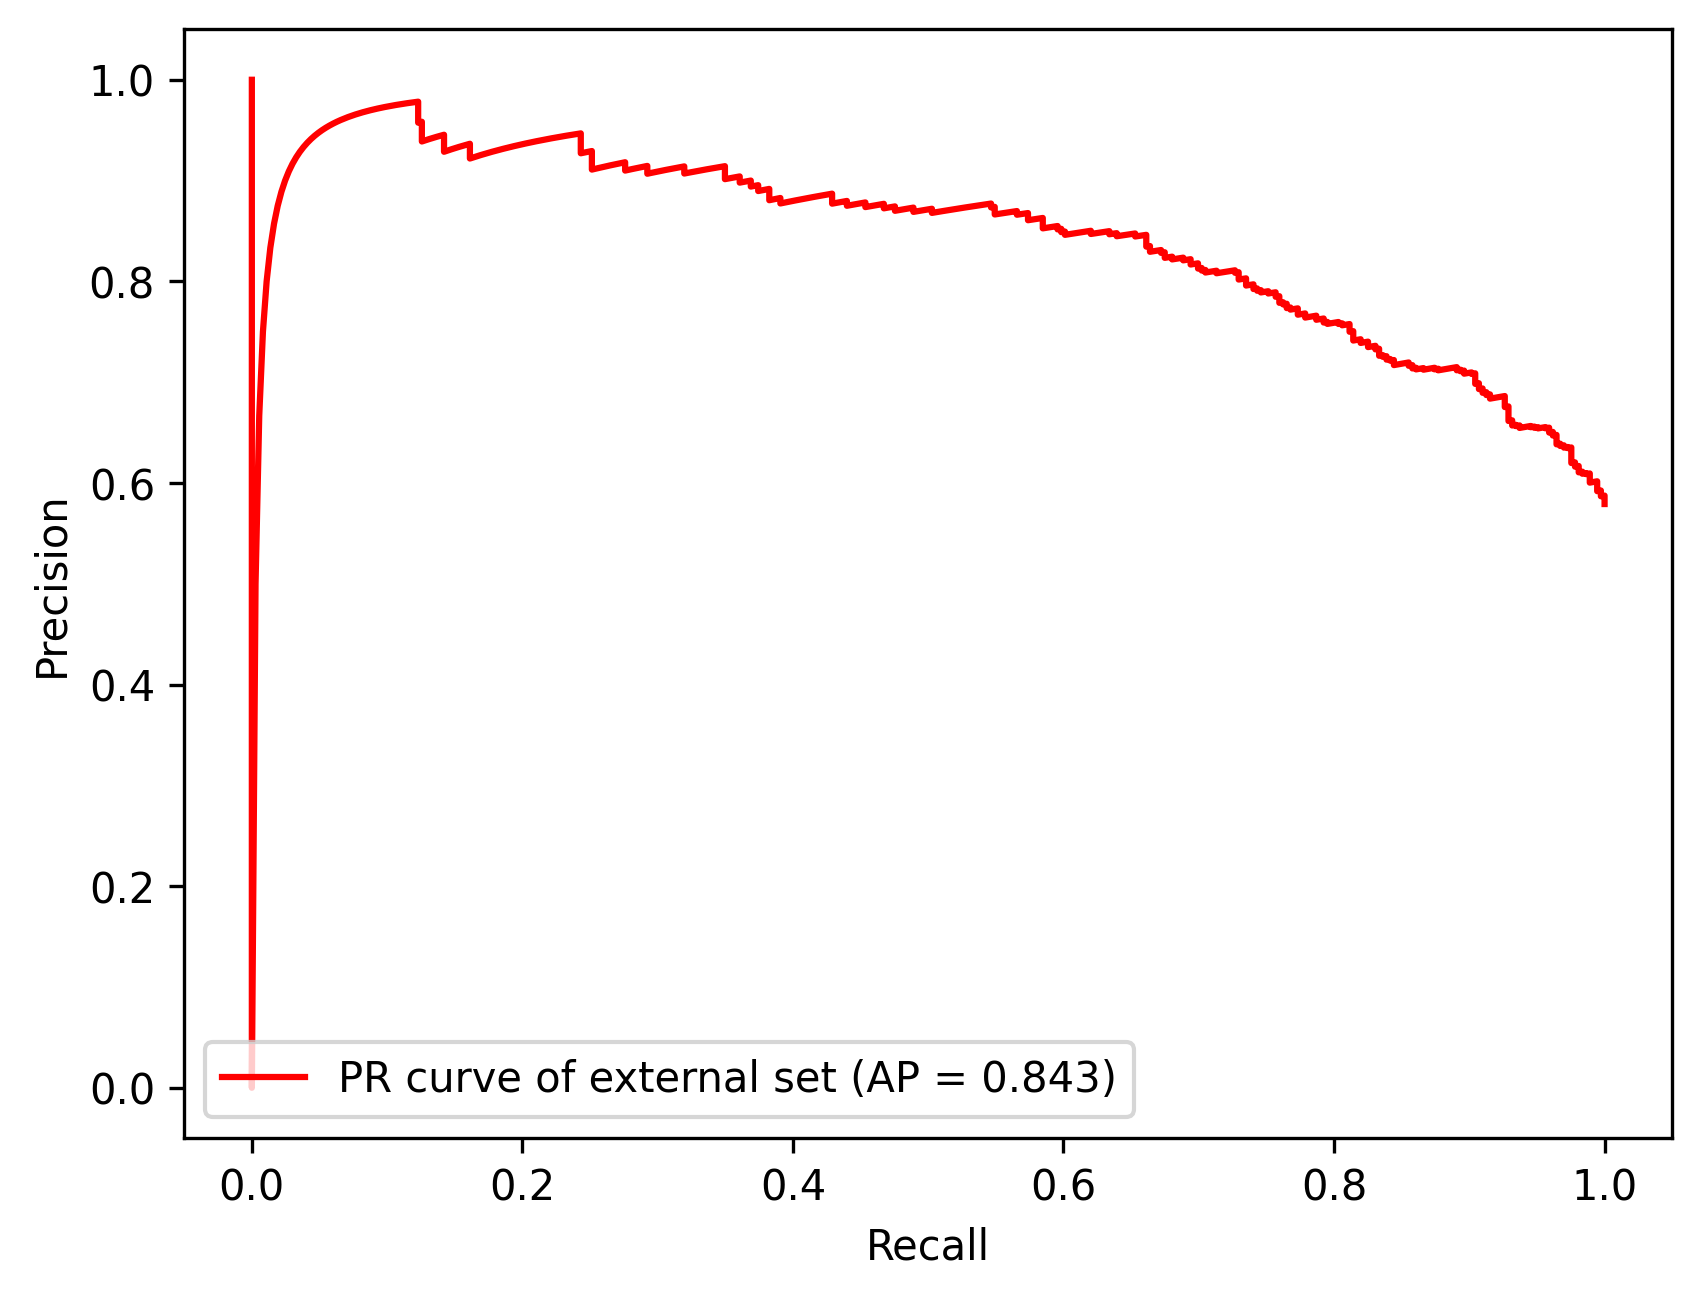

In [109]:
plt.figure(dpi=300)
plt.plot(r_test,p_test,color='red',label='PR curve of external set (AP = {:.3f})'.format(ap_test))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc=3)

In [10]:
ys_train = []
ys_vali = []
pros_train = []
pros_vali = []
for index,(train_index,vali_index) in enumerate(sp.split(train,train['type'])):
    data_train = train.iloc[train_index,:]
    data_vali = train.iloc[vali_index,:]
    X_train = data_train.iloc[:,1:-1]
    y_train = data_train.iloc[:,-1]
    X_vali = data_vali.iloc[:,1:-1]
    y_vali = data_vali.iloc[:,-1]
    X_train,y_train = ous.fit_resample(X_train,y_train)

    model = Sequential()
    model.add(Dense(units=39,input_dim=85,activation='relu'))
    model.add(Dropout(0.5922756737163298))
    model.add(Dense(units=75,activation='relu'))
    model.add(Dropout(0.24259120546024865))
    model.add(Dense(units=97,activation='relu'))
    model.add(Dropout(0.024606085997426252))
    model.add(Dense(units=1,activation='sigmoid'))

    call = EarlyStopping(monitor='val_auc',mode='max')
    op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
    model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

    model.fit(X_train,y_train,epochs=500,batch_size=1000,callbacks=call,validation_data=(X_vali,y_vali))

    pro_train = model.predict(X_train)
    pro_vali = model.predict(X_vali)
    ys_train.append(y_train)
    ys_vali.append(y_vali)
    pros_train.append(pro_train)
    pros_vali.append(pro_vali)

Epoch 1/500
8/8 [==============================] - 2s 48ms/step - loss: 0.6828 - auc: 0.5940 - val_loss: 0.5118 - val_auc: 0.8160
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5853 - auc: 0.7622 - val_loss: 0.5587 - val_auc: 0.8357
Epoch 3/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5496 - auc: 0.7974 - val_loss: 0.5379 - val_auc: 0.8435
Epoch 4/500
41/41 [==============================] - 0s 1ms/step
Epoch 1/500
8/8 [==============================] - 1s 37ms/step - loss: 0.6884 - auc: 0.6061 - val_loss: 0.5568 - val_auc: 0.8049
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5881 - auc: 0.7542 - val_loss: 0.5201 - val_auc: 0.8226
Epoch 3/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5462 - auc: 0.8003 - val_loss: 0.5282 - val_auc: 0.8311
Epoch 4/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5313 - auc: 0.8152 - val_loss: 0.5120 - val_auc: 0.8343
Epoch 5/500
41/41 [======

In [11]:
from sklearn.calibration import calibration_curve

In [46]:
true_train_1,pre_train_1 = calibration_curve(ys_train[0],pros_train[0],n_bins=5)
true_vali_1,pre_vali_1 = calibration_curve(ys_vali[0],pros_vali[0],n_bins=5)
true_train_2,pre_train_2 = calibration_curve(ys_train[1],pros_train[1],n_bins=5)
true_vali_2,pre_vali_2 = calibration_curve(ys_vali[1],pros_vali[1],n_bins=5)
true_train_3,pre_train_3 = calibration_curve(ys_train[2],pros_train[2],n_bins=5)
true_vali_3,pre_vali_3 = calibration_curve(ys_vali[2],pros_vali[2],n_bins=5)
true_train_4,pre_train_4 = calibration_curve(ys_train[3],pros_train[3],n_bins=5)
true_vali_4,pre_vali_4 = calibration_curve(ys_vali[3],pros_vali[3],n_bins=5)
true_train_5,pre_train_5 = calibration_curve(ys_train[4],pros_train[4],n_bins=5)
true_vali_5,pre_vali_5 = calibration_curve(ys_vali[4],pros_vali[4],n_bins=5)

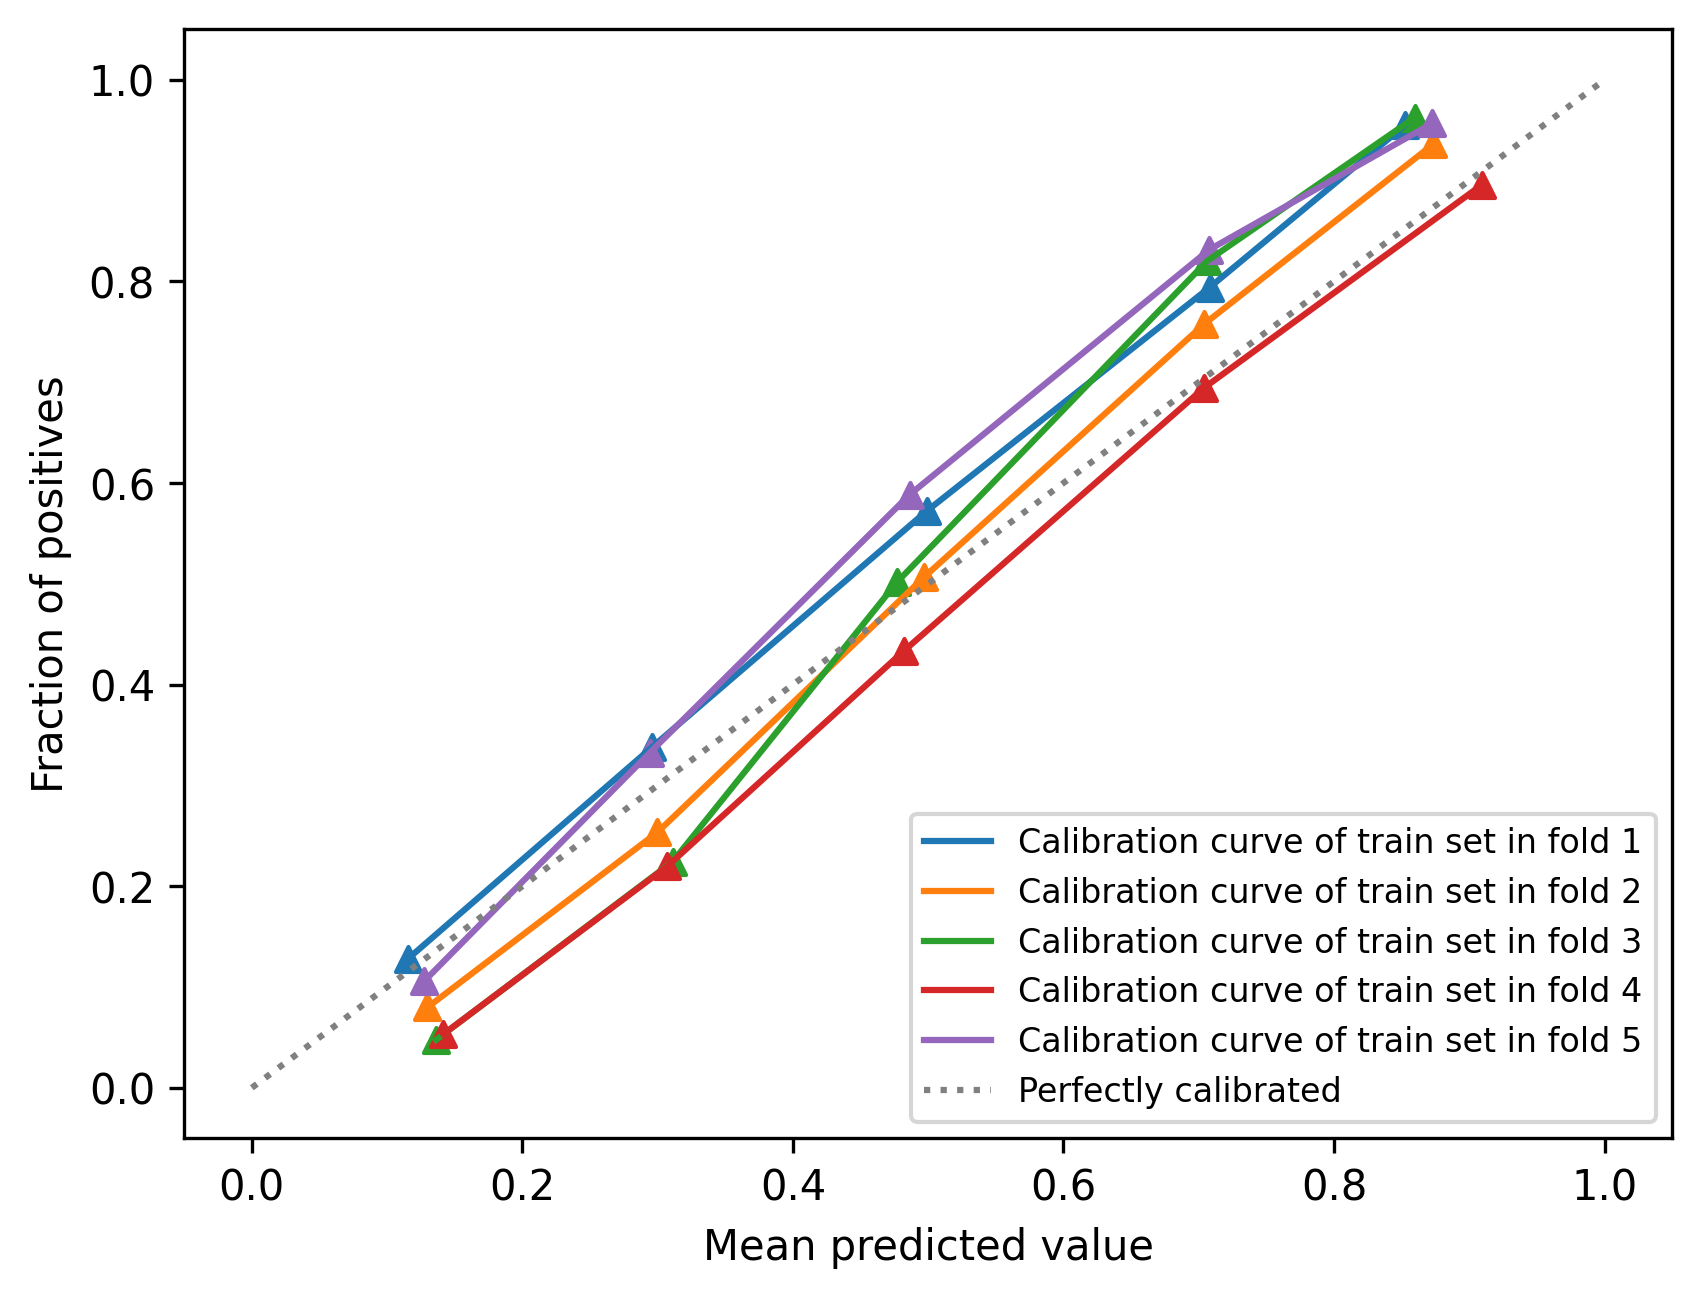

In [47]:
plt.figure(dpi=300)
plt.plot(pre_train_1,true_train_1,label='Calibration curve of train set in fold 1')
plt.plot(pre_train_2,true_train_2,label='Calibration curve of train set in fold 2')
plt.plot(pre_train_3,true_train_3,label='Calibration curve of train set in fold 3')
plt.plot(pre_train_4,true_train_4,label='Calibration curve of train set in fold 4')
plt.plot(pre_train_5,true_train_5,label='Calibration curve of train set in fold 5')
plt.scatter(pre_train_1,true_train_1,marker='^')
plt.scatter(pre_train_2,true_train_2,marker='^')
plt.scatter(pre_train_3,true_train_3,marker='^')
plt.scatter(pre_train_4,true_train_4,marker='^')
plt.scatter(pre_train_5,true_train_5,marker='^')
plt.plot([0,1],[0,1],':',label='Perfectly calibrated',color='grey')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend(prop={'size':8},loc=4)

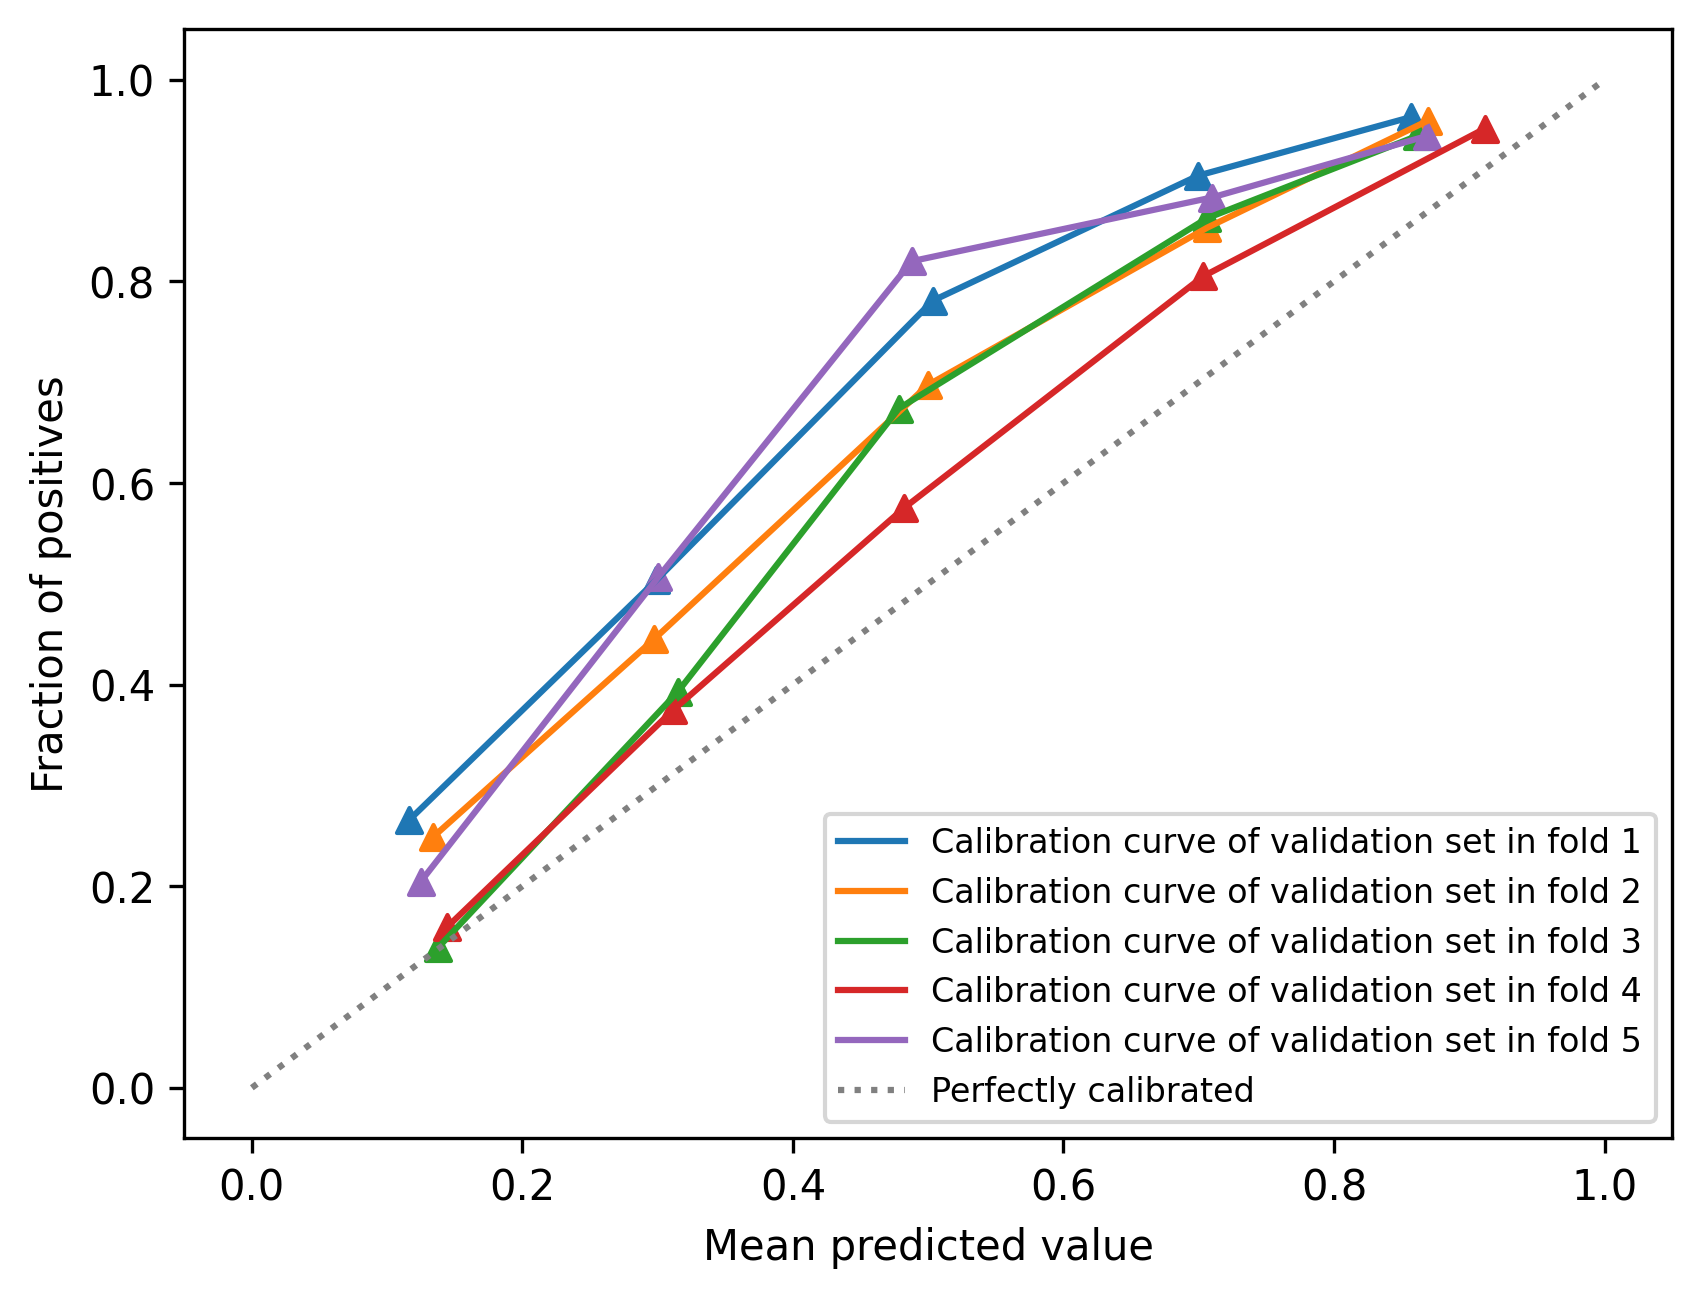

In [48]:
plt.figure(dpi=300)
plt.plot(pre_vali_1,true_vali_1,label='Calibration curve of validation set in fold 1')
plt.plot(pre_vali_2,true_vali_2,label='Calibration curve of validation set in fold 2')
plt.plot(pre_vali_3,true_vali_3,label='Calibration curve of validation set in fold 3')
plt.plot(pre_vali_4,true_vali_4,label='Calibration curve of validation set in fold 4')
plt.plot(pre_vali_5,true_vali_5,label='Calibration curve of validation set in fold 5')
plt.scatter(pre_vali_1,true_vali_1,marker='^')
plt.scatter(pre_vali_2,true_vali_2,marker='^')
plt.scatter(pre_vali_3,true_vali_3,marker='^')
plt.scatter(pre_vali_4,true_vali_4,marker='^')
plt.scatter(pre_vali_5,true_vali_5,marker='^')
plt.plot([0,1],[0,1],':',label='Perfectly calibrated',color='grey')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend(prop={'size':8},loc=4)

In [35]:
test = pd.read_csv('data_test.csv')
X_test = test.iloc[:,1:-1]
y_test = test.iloc[:,-1]

X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])

model = Sequential()
model.add(Dense(units=39,input_dim=85,activation='relu'))
model.add(Dropout(0.5922756737163298))
model.add(Dense(units=75,activation='relu'))
model.add(Dropout(0.24259120546024865))
model.add(Dense(units=97,activation='relu'))
model.add(Dropout(0.024606085997426252))
model.add(Dense(units=1,activation='sigmoid'))

call = EarlyStopping(monitor='val_auc',mode='max')
op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

his = model.fit(X_new,y_new,batch_size=1000,epochs=7)

pro_test = model.predict(X_test)

Epoch 1/7
9/9 [==============================] - 1s 6ms/step - loss: 0.6596 - auc: 0.6454
Epoch 2/7
9/9 [==============================] - 0s 6ms/step - loss: 0.5613 - auc: 0.7850
Epoch 3/7
9/9 [==============================] - 0s 6ms/step - loss: 0.5320 - auc: 0.8117
Epoch 4/7
9/9 [==============================] - 0s 6ms/step - loss: 0.5191 - auc: 0.8222
Epoch 5/7
9/9 [==============================] - 0s 5ms/step - loss: 0.5089 - auc: 0.8299
Epoch 6/7
9/9 [==============================] - 0s 6ms/step - loss: 0.4975 - auc: 0.8376
Epoch 7/7
20/20 [==============================] - 0s 945us/step


In [49]:
true_test,pre_test = calibration_curve(y_test,pro_test,n_bins=5)

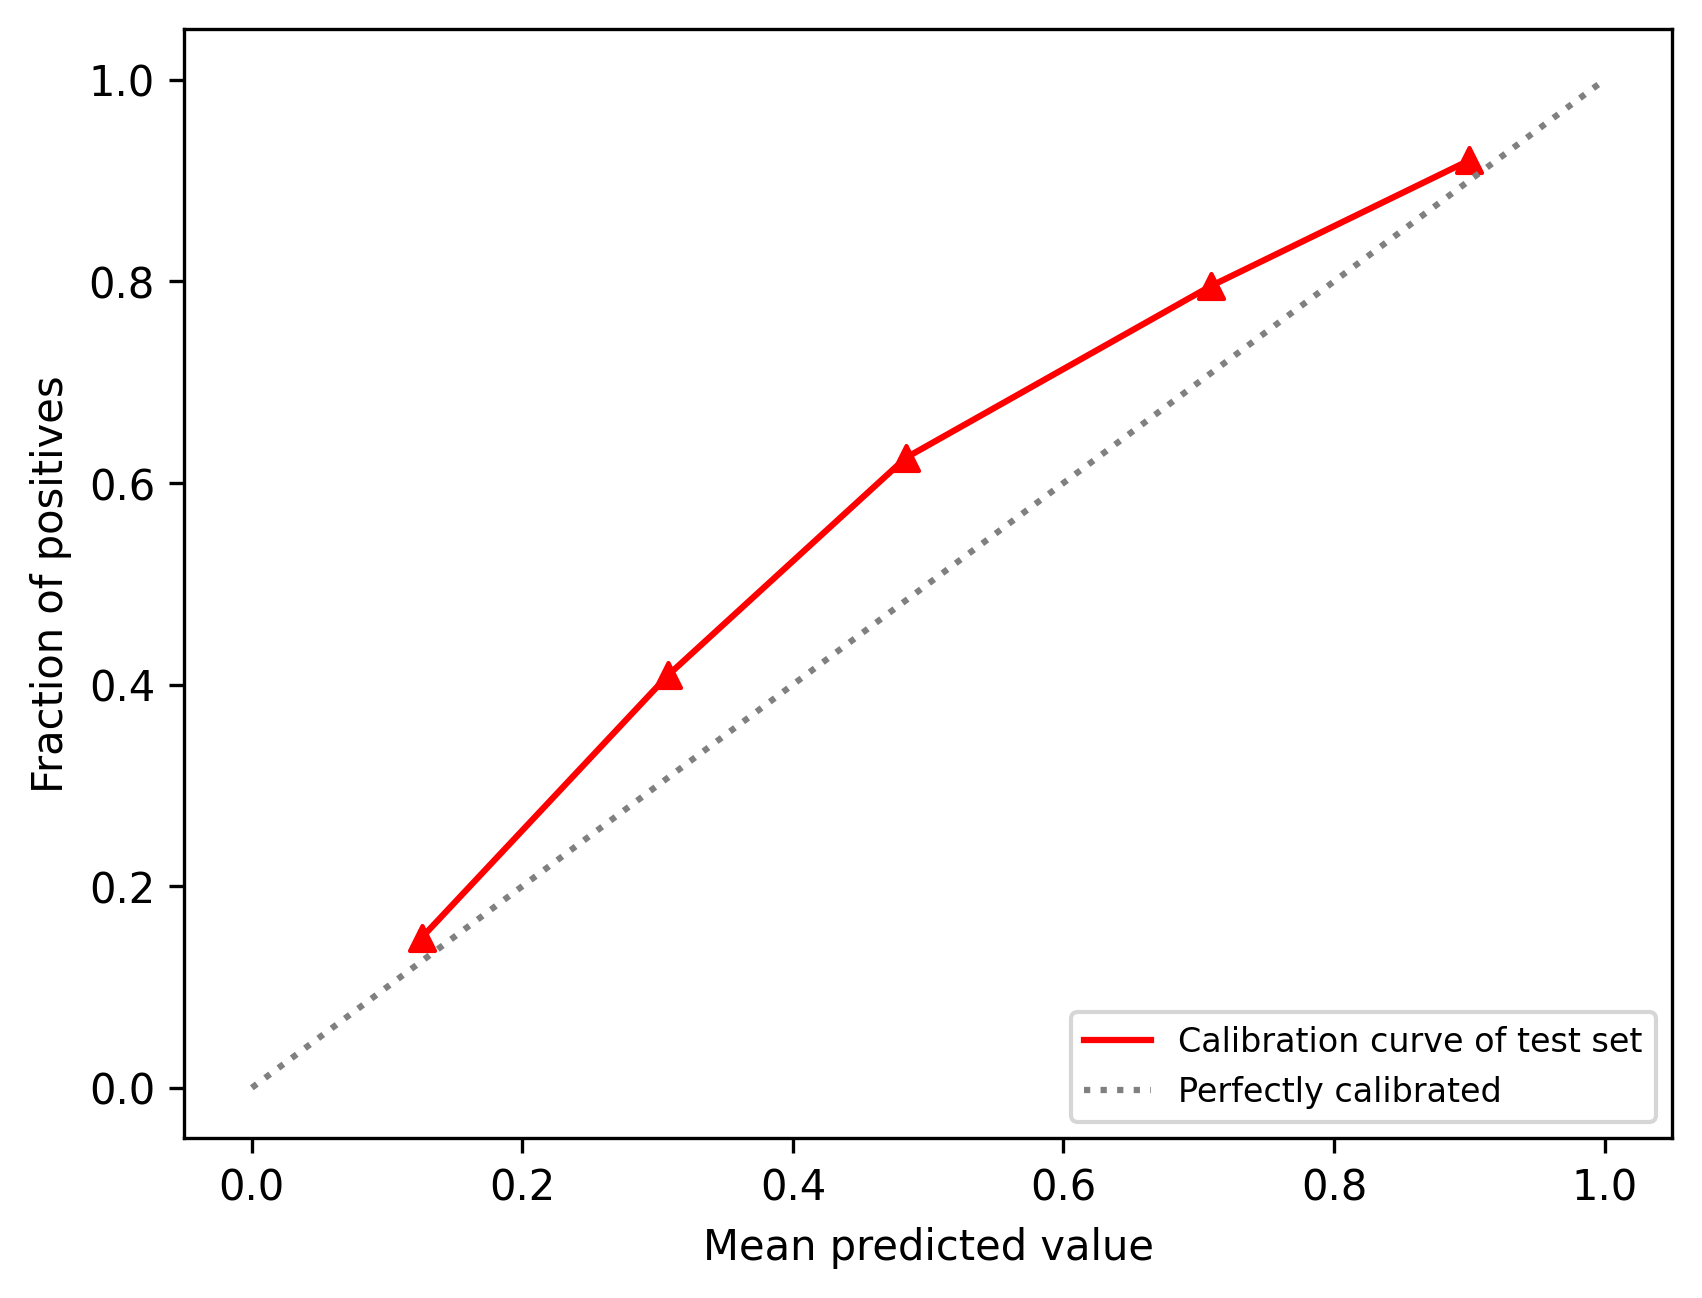

In [54]:
plt.figure(dpi=300)
plt.plot(pre_test,true_test,color='red',label='Calibration curve of test set')
plt.scatter(pre_test,true_test,color='red',marker='^')
plt.plot([0,1],[0,1],':',label='Perfectly calibrated',color='grey')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.legend(loc=4,prop={'size':8})

In [13]:
for index,(train_index,vali_index) in enumerate(sp.split(train,train['type'])):
    data_train = train.iloc[train_index,:]
    data_vali = train.iloc[vali_index,:]
    X_train = data_train.iloc[:,1:-1]
    y_train = data_train.iloc[:,-1]
    X_vali = data_vali.iloc[:,1:-1]
    y_vali = data_vali.iloc[:,-1]
    X_train,y_train = ous.fit_resample(X_train,y_train)

    model = Sequential()
    model.add(Dense(units=39,input_dim=85,activation='relu'))
    model.add(Dropout(0.5922756737163298))
    model.add(Dense(units=75,activation='relu'))
    model.add(Dropout(0.24259120546024865))
    model.add(Dense(units=97,activation='relu'))
    model.add(Dropout(0.024606085997426252))
    model.add(Dense(units=1,activation='sigmoid'))

    call = EarlyStopping(monitor='val_auc',mode='max')
    op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
    model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

    model.fit(X_train,y_train,epochs=500,batch_size=1000,callbacks=call,validation_data=(X_vali,y_vali))

    pro_train = model.predict(X_train)
    pro_vali = model.predict(X_vali)

    df_train = pd.concat([pd.DataFrame(y_train).reset_index(drop=True),pd.DataFrame(pro_train).reset_index(drop=True)],ignore_index=True,axis=1)
    df_vali = pd.concat([pd.DataFrame(y_vali).reset_index(drop=True),pd.DataFrame(pro_vali).reset_index(drop=True)],ignore_index=True,axis=1)

    df_train.to_csv('./DCA/df_train_{}.csv'.format(index))
    df_vali.to_csv('./DCA/df_vali_{}.csv'.format(index))

Epoch 1/500
8/8 [==============================] - 3s 141ms/step - loss: 0.6689 - auc: 0.6349 - val_loss: 0.5494 - val_auc: 0.8161
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 0.5674 - auc: 0.7806 - val_loss: 0.5552 - val_auc: 0.8344
Epoch 3/500
41/41 [==============================] - 0s 2ms/step
Epoch 1/500
8/8 [==============================] - 3s 85ms/step - loss: 0.6621 - auc: 0.6390 - val_loss: 0.5780 - val_auc: 0.8212
Epoch 2/500
8/8 [==============================] - 0s 30ms/step - loss: 0.5734 - auc: 0.7742 - val_loss: 0.5060 - val_auc: 0.8354
Epoch 3/500
41/41 [==============================] - 0s 2ms/step
Epoch 1/500
8/8 [==============================] - 3s 89ms/step - loss: 0.6596 - auc: 0.6427 - val_loss: 0.5591 - val_auc: 0.7994
Epoch 2/500
8/8 [==============================] - 0s 23ms/step - loss: 0.5725 - auc: 0.7732 - val_loss: 0.5947 - val_auc: 0.8115
Epoch 3/500
8/8 [==============================] - 0s 24ms/step - loss: 0.5501 - auc: 0.7

In [36]:
from dcurves import dca, plot_graphs
import matplotlib.pyplot as plt

In [59]:
data = pd.read_csv('./DCA/df_vali_4.csv')

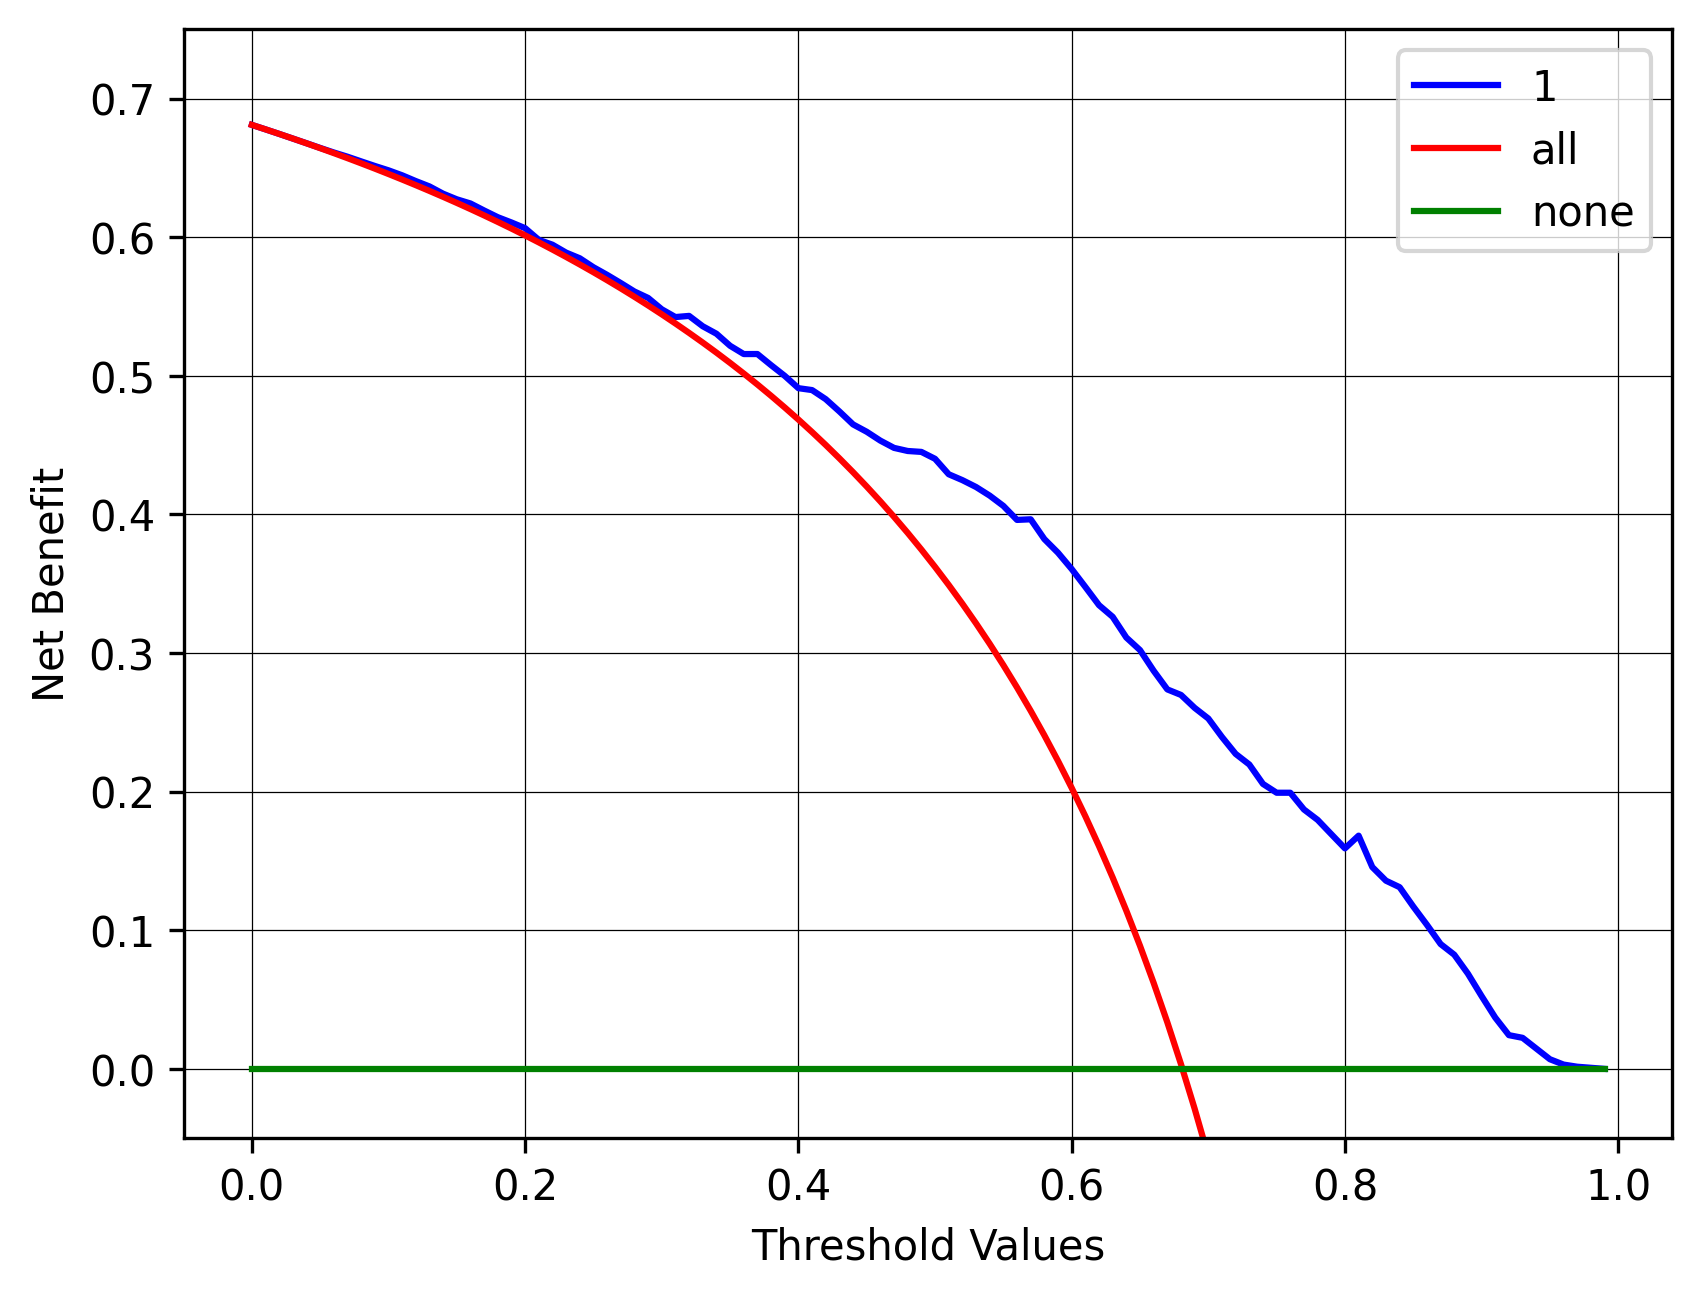

In [60]:
plt.figure(dpi=300)
dca_df = \
    dca(
        data=data,
        outcome='0',
        modelnames=['1']
    )

plot_graphs(
    plot_df=dca_df,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.75],
    color_names=['blue','red','green']
)

In [65]:
test = pd.read_csv('data_test.csv')
X_test = test.iloc[:,1:-1]
y_test = test.iloc[:,-1]

X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])

model = Sequential()
model.add(Dense(units=39,input_dim=85,activation='relu'))
model.add(Dropout(0.5922756737163298))
model.add(Dense(units=75,activation='relu'))
model.add(Dropout(0.24259120546024865))
model.add(Dense(units=97,activation='relu'))
model.add(Dropout(0.024606085997426252))
model.add(Dense(units=1,activation='sigmoid'))

call = EarlyStopping(monitor='val_auc',mode='max')
op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)

his = model.fit(X_new,y_new,batch_size=1000,epochs=7)

pro_test = model.predict(X_test)

df_test = pd.concat([pd.DataFrame(y_test).reset_index(drop=True),pd.DataFrame(pro_test).reset_index(drop=True)],ignore_index=True,axis=1)
df_test.columns = ['type','pro']

Epoch 1/7
9/9 [==============================] - 2s 9ms/step - loss: 0.6646 - auc: 0.6334
Epoch 2/7
9/9 [==============================] - 0s 8ms/step - loss: 0.5655 - auc: 0.7816
Epoch 3/7
9/9 [==============================] - 0s 9ms/step - loss: 0.5321 - auc: 0.8123
Epoch 4/7
9/9 [==============================] - 0s 8ms/step - loss: 0.5193 - auc: 0.8232
Epoch 5/7
9/9 [==============================] - 0s 8ms/step - loss: 0.5088 - auc: 0.8305
Epoch 6/7
9/9 [==============================] - 0s 8ms/step - loss: 0.5053 - auc: 0.8333
Epoch 7/7
20/20 [==============================] - 0s 1ms/step


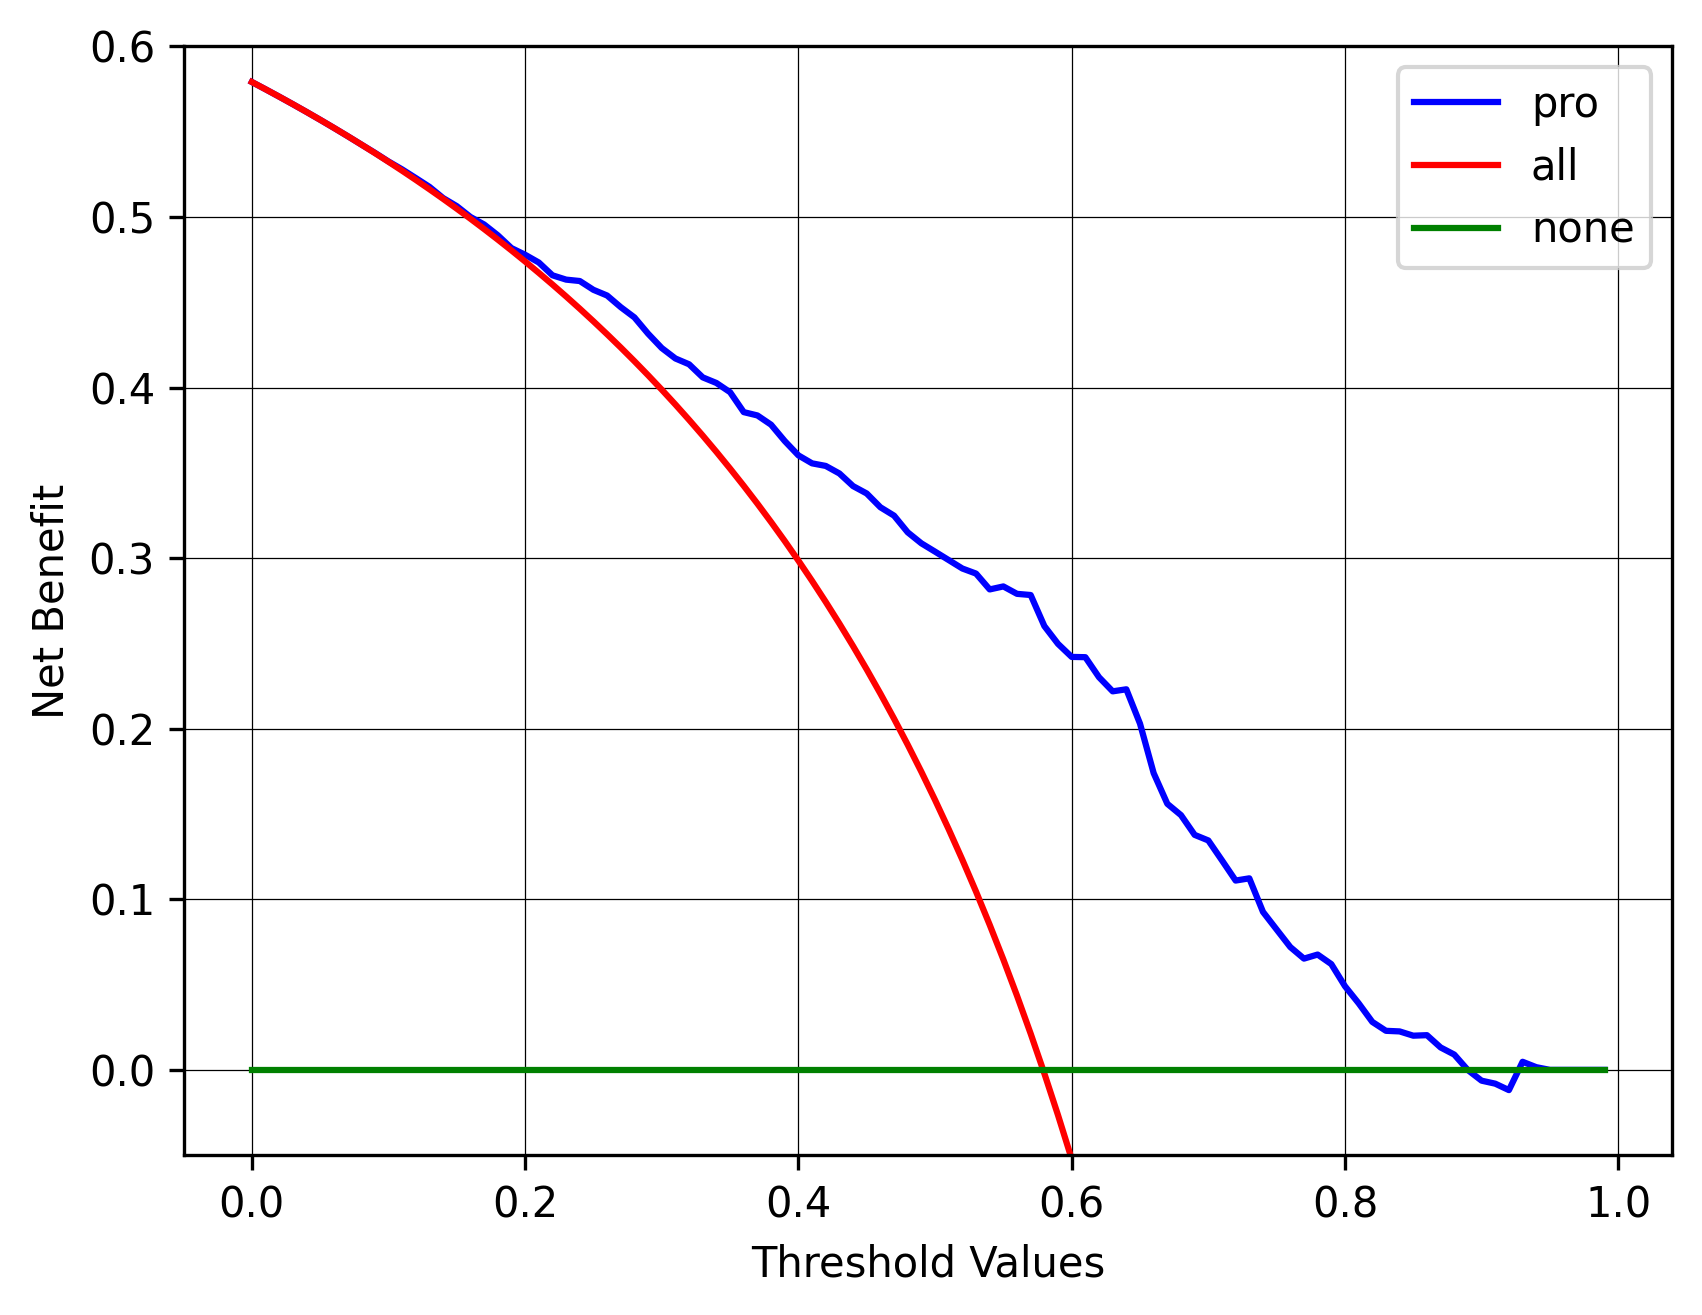

In [67]:
plt.figure(dpi=300)
dca_df = \
    dca(
        data=df_test,
        outcome='type',
        modelnames=['pro']
    )

plot_graphs(
    plot_df=dca_df,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.6],
    color_names=['blue','red','green']
)

In [75]:
# Calculate SHAP Value

In [13]:
X_new,y_new = ous.fit_resample(train.iloc[:,1:-1],train['type'])
model = Sequential()
model.add(Dense(units=39,input_dim=85,activation='relu'))
model.add(Dropout(0.5922756737163298))
model.add(Dense(units=75,activation='relu'))
model.add(Dropout(0.24259120546024865))
model.add(Dense(units=97,activation='relu'))
model.add(Dropout(0.024606085997426252))
model.add(Dense(units=1,activation='sigmoid'))
call = EarlyStopping(monitor='val_auc',mode='max')
op = Adam(learning_rate=0.008017269518094929,beta_1=0.5533628888067178,beta_2=0.7147232869127088)
model.compile(loss='BinaryCrossentropy',metrics='AUC',optimizer=op)
his = model.fit(X_new,y_new,batch_size=1000,epochs=7)

Epoch 1/7
9/9 [==============================] - 2s 10ms/step - loss: 0.6273 - auc: 0.7016
Epoch 2/7
9/9 [==============================] - 0s 9ms/step - loss: 0.5525 - auc: 0.7932
Epoch 3/7
9/9 [==============================] - 0s 8ms/step - loss: 0.5305 - auc: 0.8116
Epoch 4/7
9/9 [==============================] - 0s 7ms/step - loss: 0.5187 - auc: 0.8232
Epoch 5/7
9/9 [==============================] - 0s 8ms/step - loss: 0.5090 - auc: 0.8302
Epoch 6/7
9/9 [==============================] - 0s 7ms/step - loss: 0.4995 - auc: 0.8367
Epoch 7/7
9/9 [==============================] - 0s 7ms/step - loss: 0.4996 - auc: 0.8360


In [17]:
#保存模型
model.save('./Kerasmodel.h5')

D:\Users\YanceYang\anaconda3\envs\normdata\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
df = pd.read_csv('df.csv')
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

In [97]:
id = pd.read_csv('data.csv')

In [101]:
import shap
import pickle
import matplotlib.pyplot as plt
with open('onehot.save', 'rb') as f:
    onehot = pickle.load(f)

In [98]:
reverse_X = pd.DataFrame(onehot.inverse_transform(X))
reverse_X.columns = id.iloc[:,1:-1].columns

In [110]:
def f(X):
    pro = model.predict(X)
    pre = np.where(pro>=0.45,1,0)
    return pre

In [81]:
#ALL

In [85]:
explainer = shap.KernelExplainer(f,X.iloc[0:100,:])
shap_value_all = explainer.shap_values(X.iloc[1000:2000,:],nsamples=200)

4/4 [==============================] - 0s 5ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

625/625 [==============================] - 1s 1ms/step


In [89]:
shap_value_all_df = pd.DataFrame(shap_value_all[:,:,0])
shap_value_all_df.columns = X.columns
shap_value_all_df.to_csv('shap_all.csv')

In [92]:
shap_value_all_df = np.array(pd.read_csv('shap_all.csv'))

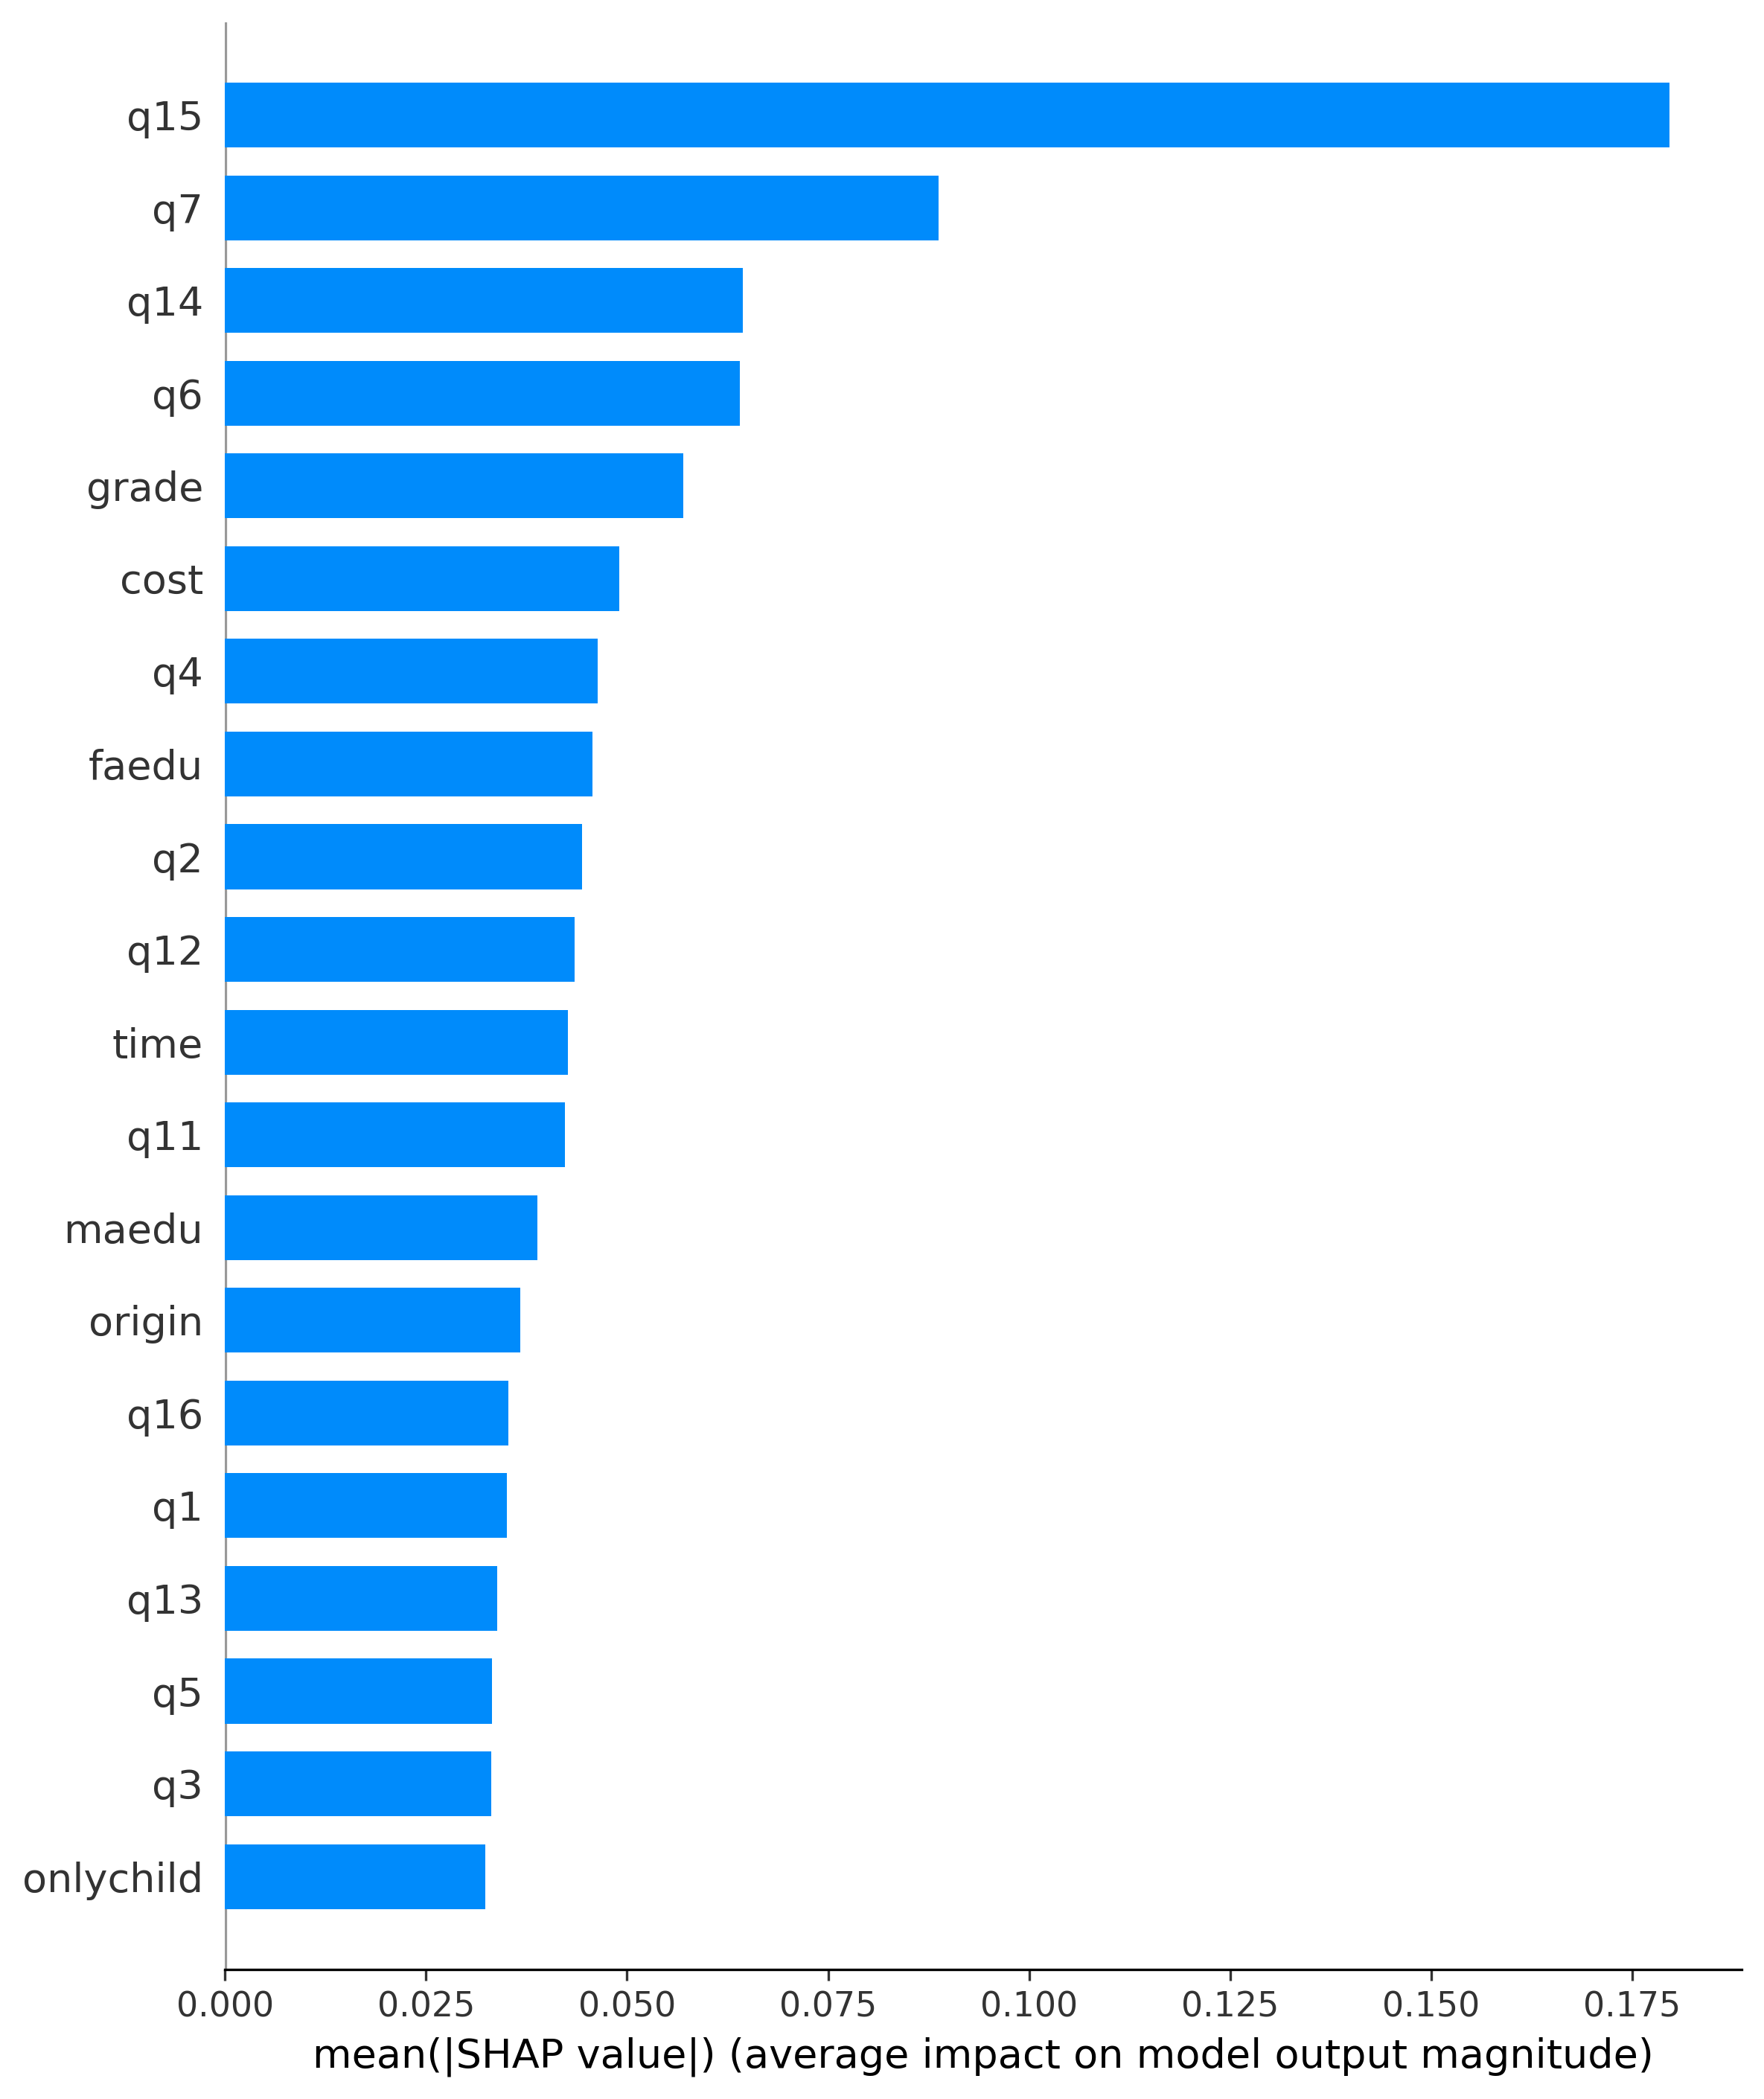

In [103]:
plt.figure(dpi=300)
shap.summary_plot(shap_value_all_df,reverse_X.iloc[1000:2000,:],plot_type='bar')

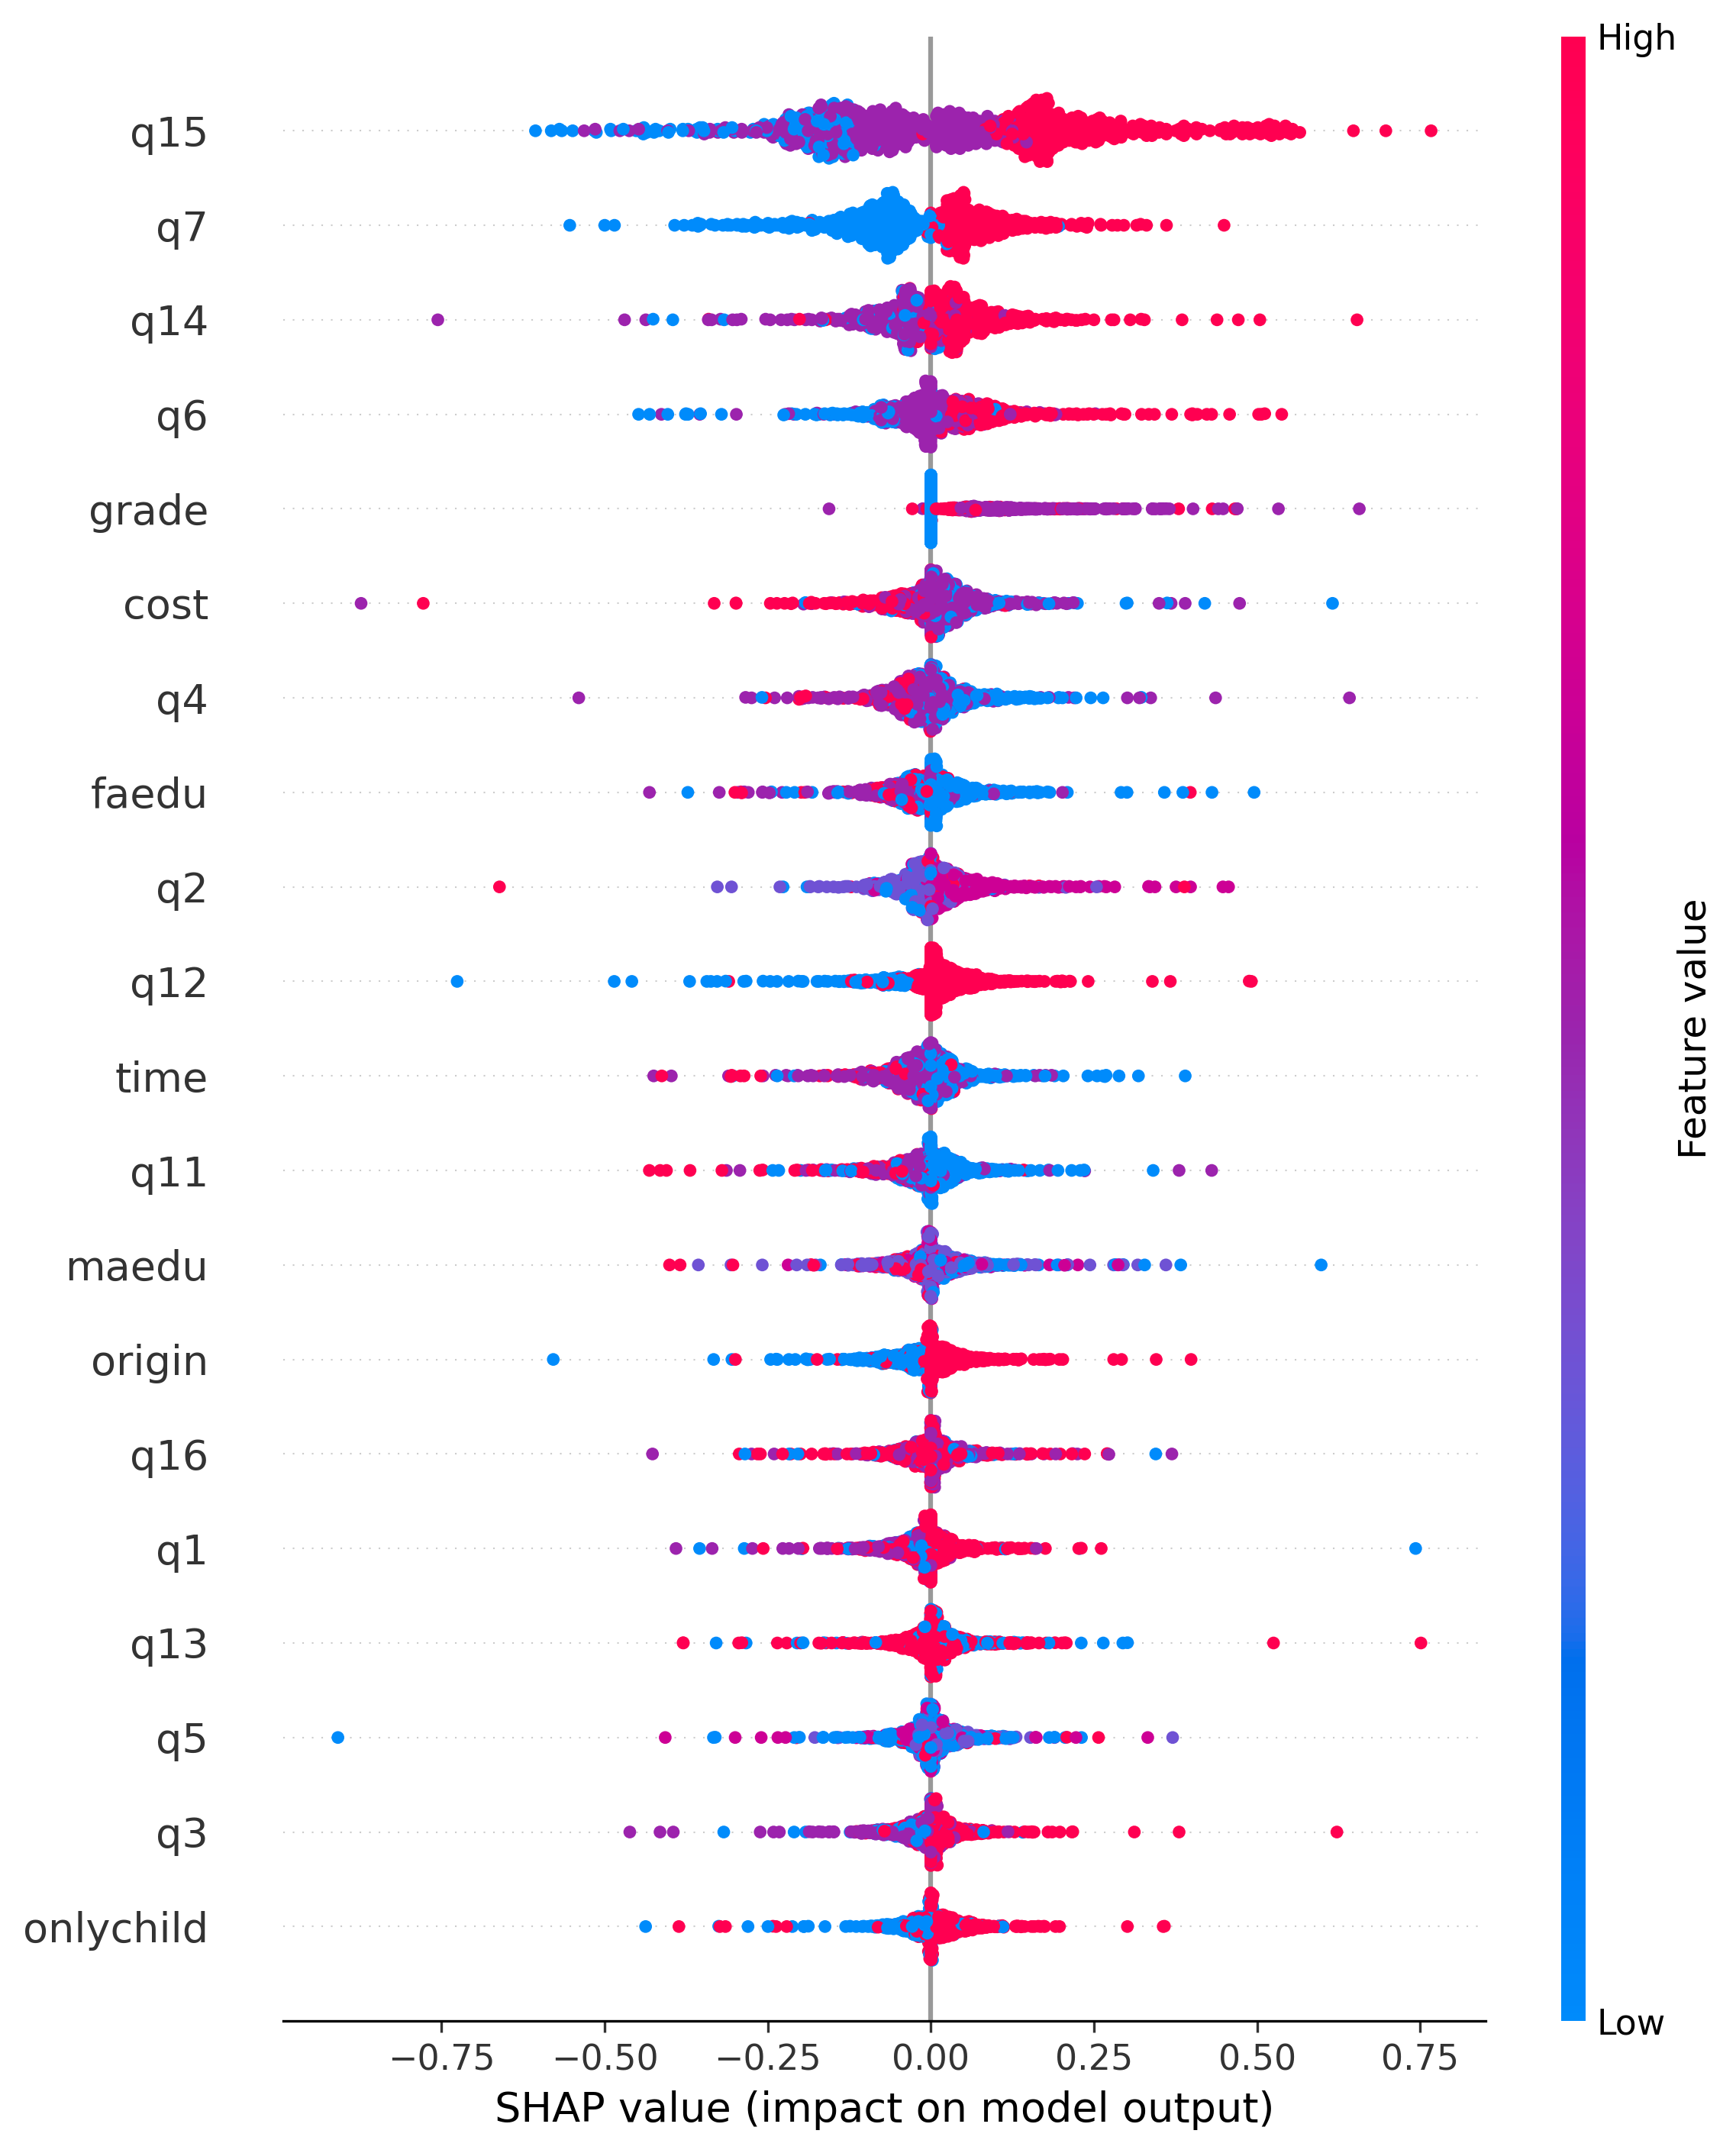

In [104]:
plt.figure(dpi=300)
shap.summary_plot(shap_value_all_df,reverse_X.iloc[1000:2000,:])